# Predicting Gentrification
*A study into planning application features that can help to signal early warnings of gentrification*
</br></br></br></br>
Author: Mariia Shapovalova</br>
Date: April, 2023

---
## Table of Contents
Chicago Planning Application Dataset
- 0.0 Introduction
- 1.0 Initial Exploration
- 2.0 Initial Cleaning
- 3.0 Infer Missing Census Tracts


---
*<center><h2> Introduction <center><h2>*

### Introduction to The Project



My goal is to 123



### Introduction to this Notebook 


The purpose of this notebook is to understand, clean and conduct initial EDA of Chicago Planning Application Dataset. </br>
The dataset was downloaded from Chicago Data Portal, which can be accessed using the following link [Planning Applications Link](https://data.cityofchicago.org/Buildings/Building-Permits/ydr8-5enu).

---
*<center><h2> Initial Exploration<center><h2>*

In [321]:
def get_columns_with_regex(df,reg_exp=None):
    '''
    Use:
        Returns a filtered dataframe that contains columns with names that match the given regular expression.
    Input:
        df (pandas.core.frame.DataFrame): The dataframe to be filtered.
        reg_exp (str): The regular expression to match against column names. Default is None
    Return:
        pandas.core.frame.DataFrame: A new dataframe containing only columns that match the regular expression.
    
    '''
    try:
        if reg_exp is None:
            return df
        else:
            filtered_df = df.loc[:, [bool(re.search(reg_exp, col)) for col in df.columns]]
            return filtered_df

    except re.error:
        raise ValueError(f"{reg_exp} is not a valid regular expression")

#This function will be placed in the functions.py file to be accessed in the other notebooks
#import re

In [314]:
def overview (df):
    '''
    Use:
        Provides a high-level overview of the input dataframe.
    Input:
        df [pandas.core.frame.DataFrame] : df to be analysed
    Return:
        - Print the shape of the input dataframe
        - pandas.core.frame.DataFrame : df containing overview of the column data types, null values, and sample rows

    '''
    #print df shape
    print(f'The dataframe shape is {df.shape}')
    # Create new dataframe with data types, null values, and sample row information
    preview_df=pd.DataFrame({
        #data types for each columns
        'Data Types':df.dtypes,\
        #absolute number of null values in each column
        'Total Null Values':df.isna().sum(), \
        #percentage number of null values in each column
        'Null Values Percentage':df.isna().sum()*100/df.shape[0],\
        #first row
        'Sample Value Head':df.head(1).T.iloc[:,0],\
        #last row
        'Sample Value Tail':df.tail(1).T.iloc[:,0],\
        #random sample row
        'Sample Value':df.sample().T.iloc[:,0]})

    # Rename index axis
    preview_df.rename_axis('Column_Name',inplace=True)
    return preview_df

In [748]:
#import relevant packages
import numpy as np
import pandas as pd

import joblib
import re

import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

#requires pip install censusgeocode
import censusgeocode as cg

#from functions import *

### 1.1 Importing Data

In [332]:
#load data
permits_raw=pd.read_csv('../src/data/Building_Permits.csv')

* Check that data was imported correctly

In [346]:
#preview top 5 rows
permits_raw.head()

,ID,PERMIT#,PERMIT_TYPE,REVIEW_TYPE,APPLICATION_START_DATE,ISSUE_DATE,PROCESSING_TIME,STREET_NUMBER,STREET DIRECTION,STREET_NAME,...,PIN9,PIN10,COMMUNITY_AREA,CENSUS_TRACT,WARD,XCOORDINATE,YCOORDINATE,LATITUDE,LONGITUDE,LOCATION
0,1614287,100072880,PERMIT - RENOVATION/ALTERATION,STANDARD PLAN REVIEW,10/14/2005,01/03/2006,81.0,2728,N,MONTICELLO,...,NaN,NaN,NaN,NaN,NaN,1.151539e+06,1.918031e+06,41.930957,-87.718543,POINT (-87.718542820893 41.930957454144)
1,1614342,100072909,PERMIT - NEW CONSTRUCTION,STANDARD PLAN REVIEW,12/05/2005,03/29/2006,114.0,1409,S,KEDVALE,...,NaN,NaN,NaN,NaN,NaN,1.148986e+06,1.892939e+06,41.862155,-87.728575,POINT (-87.728575200899 41.862154886848)
2,1614371,100072936,PERMIT - SIGNS,SIGN PERMIT,10/17/2005,01/12/2006,87.0,120,S,LA SALLE,...,NaN,NaN,NaN,NaN,NaN,1.175112e+06,1.899771e+06,41.880356,-87.632466,POINT (-87.632466106592 41.880356217665)
3,1637148,100086388,PERMIT - RENOVATION/ALTERATION,SELF CERT,01/25/2006,01/26/2006,1.0,71,S,WACKER,...,NaN,NaN,NaN,NaN,NaN,1.173988e+06,1.899894e+06,41.880718,-87.636589,POINT (-87.636589107372 41.880717575265)
4,1637165,100086395,PERMIT - RENOVATION/ALTERATION,SELF CERT,01/21/2006,01/21/2006,0.0,4901,S,CICERO,...,NaN,NaN,NaN,NaN,NaN,1.145226e+06,1.871678e+06,41.803882,-87.742911,POINT (-87.742911007932 41.80388237071)


***What is the shape of the dataset and what columns are included?***

In [330]:
#apply a custom function 'overview' to create a dataframe 'raw_overview' that provides a high level summary of each column
raw_overview=overview(permits_raw)

The dataframe shape is (730511, 119)


,Data Types,Total Null Values,Null Values Percentage,Sample Value Head,Sample Value Tail,Sample Value
Column_Name,,,,,,
ID,int64,0,0.000000,1614287,3308675,2642790
PERMIT#,object,0,0.000000,100072880,101006675,100586681
PERMIT_TYPE,object,0,0.000000,PERMIT - RENOVATION/ALTERATION,PERMIT - ELECTRIC WIRING,PERMIT - ELECTRIC WIRING
REVIEW_TYPE,object,7,0.000958,STANDARD PLAN REVIEW,EASY PERMIT WEB,EASY PERMIT WEB
APPLICATION_START_DATE,object,522,0.071457,10/14/2005,02/24/2023,03/23/2015
...,...,...,...,...,...,...
XCOORDINATE,float64,1352,0.185076,1151538.764988,1174277.877745,1167243.097321
YCOORDINATE,float64,1352,0.185076,1918030.52352,1822395.541195,1831030.327887
LATITUDE,float64,2254,0.308551,41.930957,41.668048,41.691896


* The raw planning application dataset contains `730511` rows and `119` columns. The next subsection 1.2 will aim to establish which features out of the 119 can be useful for the project

The dataset contains too many columns to be previewed at once
* Preview the first 10 columns


In [348]:
raw_overview[:10]

,Data Types,Total Null Values,Null Values Percentage,Sample Value Head,Sample Value Tail,Sample Value
Column_Name,,,,,,
ID,int64,0,0.000000,1614287,3308675,2642790
PERMIT#,object,0,0.000000,100072880,101006675,100586681
PERMIT_TYPE,object,0,0.000000,PERMIT - RENOVATION/ALTERATION,PERMIT - ELECTRIC WIRING,PERMIT - ELECTRIC WIRING
REVIEW_TYPE,object,7,0.000958,STANDARD PLAN REVIEW,EASY PERMIT WEB,EASY PERMIT WEB
APPLICATION_START_DATE,object,522,0.071457,10/14/2005,02/24/2023,03/23/2015
ISSUE_DATE,object,0,0.000000,01/03/2006,02/24/2023,03/23/2015
PROCESSING_TIME,float64,522,0.071457,81.0,0.0,0.0
STREET_NUMBER,int64,0,0.000000,2728,12423,11107
STREET DIRECTION,object,0,0.000000,N,S,S


* Preview the last 10 columns

In [356]:
raw_overview[-10:]

,Data Types,Total Null Values,Null Values Percentage,Sample Value Head,Sample Value Tail,Sample Value
Column_Name,,,,,,
PIN9,object,726951,99.512670,NaN,NaN,NaN
PIN10,object,727438,99.579336,NaN,NaN,NaN
COMMUNITY_AREA,float64,104841,14.351735,NaN,53.0,75.0
CENSUS_TRACT,float64,109049,14.927770,NaN,530503.0,750500.0
WARD,float64,105051,14.380482,NaN,34.0,34.0
XCOORDINATE,float64,1352,0.185076,1151538.764988,1174277.877745,1167243.097321
YCOORDINATE,float64,1352,0.185076,1918030.52352,1822395.541195,1831030.327887
LATITUDE,float64,2254,0.308551,41.930957,41.668048,41.691896
LONGITUDE,float64,2254,0.308551,-87.718543,-87.637825,-87.663325


***What is the timeframe of the planning application included in the dataset?***

In [354]:
#The timeframe can be determined using APPLICATION_START_DATE & ISSUE_DATE columns
fisrt_start_date=min(permits_raw['APPLICATION_START_DATE'].astype('datetime64'))
fisrt_issue_date=min(permits_raw['ISSUE_DATE'].astype('datetime64'))
last_start_date=max(permits_raw['APPLICATION_START_DATE'].astype('datetime64'))
last_issue_date=max(permits_raw['ISSUE_DATE'].astype('datetime64'))

In [355]:
print(f'The timeframe of applicatation START dates are between {fisrt_start_date} and {last_start_date}')
print(f'The timeframe of applicatation ISSUE dates are between {fisrt_issue_date} and {last_issue_date}')

The timeframe of applicatation START dates are between 2001-07-25 00:00:00 and 2023-02-24 00:00:00
The timeframe of applicatation ISSUE dates are between 2006-01-03 00:00:00 and 2023-02-24 00:00:00


* The dataset was downloaded on the 16th of February 2023, which explained why the last START and ISSUE dates are 2023-02-24
* According to Chicago Data Portal, the dataset is being updated daily

</br>

## Understanding Data
To evaluate the usability/quality of the data, let's first look at the number of nulls in each column

* Preview 10 columns with the least null values

In [335]:
#preview top 10 columns with the least null values
raw_overview.sort_values('Total Null Values').head(10)

,Data Types,Total Null Values,Null Values Percentage,Sample Value Head,Sample Value Tail,Sample Value
Column_Name,,,,,,
ID,int64,0,0.0,1614287,3308675,2642790
TOTAL_FEE,float64,0,0.0,200.0,75.0,200.0
SUBTOTAL_WAIVED,float64,0,0.0,0.0,0.0,0.0
OTHER_FEE_WAIVED,float64,0,0.0,0.0,0.0,0.0
ZONING_FEE_WAIVED,float64,0,0.0,0.0,0.0,0.0
BUILDING_FEE_WAIVED,float64,0,0.0,0.0,0.0,0.0
SUBTOTAL_UNPAID,float64,0,0.0,0.0,0.0,0.0
OTHER_FEE_UNPAID,float64,0,0.0,0.0,0.0,0.0
ZONING_FEE_UNPAID,float64,0,0.0,0.0,0.0,0.0


* Preview 10 columns with the most null values

In [334]:
#preview top 10 columns with the most null values
raw_overview.sort_values('Total Null Values',ascending=False).head(10)

,Data Types,Total Null Values,Null Values Percentage,Sample Value Head,Sample Value Tail,Sample Value
Column_Name,,,,,,
CONTACT_15_ZIPCODE,float64,730506,99.999316,NaN,NaN,NaN
CONTACT_15_TYPE,object,730506,99.999316,NaN,NaN,NaN
CONTACT_15_NAME,object,730506,99.999316,NaN,NaN,NaN
CONTACT_15_CITY,object,730506,99.999316,NaN,NaN,NaN
CONTACT_15_STATE,object,730506,99.999316,NaN,NaN,NaN
CONTACT_14_TYPE,object,730483,99.996167,NaN,NaN,NaN
CONTACT_14_NAME,object,730483,99.996167,NaN,NaN,NaN
CONTACT_14_CITY,object,730483,99.996167,NaN,NaN,NaN
CONTACT_14_ZIPCODE,object,730483,99.996167,NaN,NaN,NaN


* While there are 119 columns (potential features) in the dataset. However, some columns contain almost exclusively null values 

**What is inside the data?**

To better understand different types of columns in the dataset select columns cointaining different words such as 'FEE', 'TYPE', 'CONTACT'

In [344]:
#Using a custom function defined in functions.py select columns containing 'FEE' in its name 
get_columns_with_regex(permits_raw,'FEE').sample()

,BUILDING_FEE_PAID,ZONING_FEE_PAID,OTHER_FEE_PAID,BUILDING_FEE_UNPAID,ZONING_FEE_UNPAID,OTHER_FEE_UNPAID,BUILDING_FEE_WAIVED,ZONING_FEE_WAIVED,OTHER_FEE_WAIVED,TOTAL_FEE
511583,225.0,50.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,275.0


* Each row has data for different type of Fees Paid for each application
* Fees paid depend on the type of application and, hence, contain information about the type of application. 
* `Link to the sources`

In [345]:
#Select columns containing 'TYPE' in their names
get_columns_with_regex(permits_raw,'TYPE').sample()

,PERMIT_TYPE,REVIEW_TYPE,CONTACT_1_TYPE,CONTACT_2_TYPE,CONTACT_3_TYPE,CONTACT_4_TYPE,CONTACT_5_TYPE,CONTACT_6_TYPE,CONTACT_7_TYPE,CONTACT_8_TYPE,CONTACT_9_TYPE,CONTACT_10_TYPE,CONTACT_11_TYPE,CONTACT_12_TYPE,CONTACT_13_TYPE,CONTACT_14_TYPE,CONTACT_15_TYPE
182045,PERMIT - ELECTRIC WIRING,EASY PERMIT WEB,CONTRACTOR-ELECTRICAL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


* Different Permit, Review and Contact Types
* Each Application contains information about up to 15 contacts responsible for the project

In [342]:
#Select columns containing 'CONTACT_1' in their names to understand what type of information is provided for each contact
get_columns_with_regex(permits_raw,'CONTACT_1_').sample()

,CONTACT_1_TYPE,CONTACT_1_NAME,CONTACT_1_CITY,CONTACT_1_STATE,CONTACT_1_ZIPCODE
649160,EXPEDITOR,GC CONSULTING LLC,CHICAGO,IL,60602-


* Each Contact contains its Type (such as Architect, Contractor, Owner), Name and Contact's Local Address (City, State and Zipcode)

***

**<center><h2> INITIAL FEATURE SELECTION <center><h2>**

### Null Values and Inital Feature Selection

Let's drop columns where the number of nulls is 15% or more

In [375]:
raw_overview[raw_overview['Null Values Percentage']>=15]

,Data Types,Total Null Values,Null Values Percentage,Sample Value Head,Sample Value Tail,Sample Value
Column_Name,,,,,,
CONTACT_2_TYPE,object,277310,37.961098,ARCHITECT,NaN,NaN
CONTACT_2_NAME,object,277310,37.961098,IURO ANTHONY J,NaN,NaN
CONTACT_2_CITY,object,278918,38.181218,CHICAGO,NaN,NaN
CONTACT_2_STATE,object,279326,38.237070,IL,NaN,NaN
CONTACT_2_ZIPCODE,object,290681,39.791461,60602-,NaN,NaN
...,...,...,...,...,...,...
PIN6,object,722630,98.921166,NaN,NaN,NaN
PIN7,object,725029,99.249566,NaN,NaN,NaN
PIN8,object,726086,99.394260,NaN,NaN,NaN


In [377]:
#Calculate the percentage of null rows for each column
col_non_valid=raw_overview[raw_overview['Null Values Percentage']>=15].index

#Valid columns (where the number of nulls is less than 15%)
col_valid=[col for col in permits_raw.columns if col not in col_non_valid]

In [391]:
#Drop non-valid columns
permits_wip_1=permits_raw.drop(columns=col_non_valid)

In [392]:
overview(permits_wip_1)

The dataframe shape is (730511, 40)


,Data Types,Total Null Values,Null Values Percentage,Sample Value Head,Sample Value Tail,Sample Value
Column_Name,,,,,,
ID,int64,0,0.000000,1614287,3308675,2944966
PERMIT#,object,0,0.000000,100072880,101006675,100764248
PERMIT_TYPE,object,0,0.000000,PERMIT - RENOVATION/ALTERATION,PERMIT - ELECTRIC WIRING,PERMIT - EASY PERMIT PROCESS
REVIEW_TYPE,object,7,0.000958,STANDARD PLAN REVIEW,EASY PERMIT WEB,EASY PERMIT
APPLICATION_START_DATE,object,522,0.071457,10/14/2005,02/24/2023,05/29/2018
ISSUE_DATE,object,0,0.000000,01/03/2006,02/24/2023,06/05/2018
PROCESSING_TIME,float64,522,0.071457,81.0,0.0,7.0
STREET_NUMBER,int64,0,0.000000,2728,12423,3151
STREET DIRECTION,object,0,0.000000,N,S,N


Drop  Remaining Columns not relevant for the project

In [393]:
col_drop=['PERMIT#','WARD','COMMUNITY_AREA','PIN1','CONTACT_1_NAME','CONTACT_1_ZIPCODE','XCOORDINATE','YCOORDINATE']
permits_wip_2=permits_wip_1.drop(columns=col_drop)

### Duplicates 

In [394]:
print(f"There are {permits_wip_2.duplicated().sum()} duplicate rows")

There are 0 duplicate rows


Currently no duplicates but this would need to be checked again as we refine the columns being used.

***

**<center><h2> CENSUS TRACTS CLEANING <center><h2>**

## Introduction to Census Tract Cleaning

* Census Tract Codes are key to the project as they form the link between different datasets.
* However, currently almost 15% of datapoints are missing a census tract number
* Moreover, currently provided census tracts are not all in a correct format and there might be differences in the census tract notation between the years

In [747]:
(f"Currently {permits_wip_2['CENSUS_TRACT'].isna().sum()*100/permits_wip_2.shape[0]:.2f}% of datapoints have census tracts missing")

'Currently 14.93% of datapoints have census tracts missing'

* Let's check if there are any patterns between the data of permit and its corresponding missing census_tracts

In [396]:
permits_census_nulls=permits_wip_2[permits_wip_2['CENSUS_TRACT'].isna()]
round(permits_census_nulls.groupby(permits_census_nulls['ISSUE_DATE'].astype('datetime64').dt.year).size()*100/permits_census_nulls.shape[0],2)

ISSUE_DATE
2006    42.95
2007    43.82
2008     6.04
2009     0.26
2010     0.30
2011     0.29
2012     0.24
2013     0.33
2014     0.32
2015     0.31
2016     0.35
2017     0.32
2018     0.43
2019     0.45
2020     0.53
2021     1.40
2022     1.42
2023     0.22
dtype: float64

* Most nulls in the CENSUS_TRACT column are coming from the data in 2006 & 2007. Dropping the null rows would, hence, result in loosing almost half of the data for 2006 & 2007

</br>

## Infer Census Tracts using `censusgeocode`

* Aim of this subsection is to create a dictionary `{each ID: correct census tract number}`

***Census Tract Code Notation***
* Census Tracts encompass small geographical subdivisions of a county used for statistical research
* Generally, census tracts have between 2,500 and 8,000 residents. However, as a part of this reseach it was discovered that many census tracts in Chicago contained less than 600 residents.
* Full Census Tract Code (inside one County) should contain 6 digits in total :
  *  4-digit base code (randing from 0 to 9999) 
  *  2-digit suffix (00,01,02 etc) added when the base geography is being split futher
* Census Tract Codes were updated between 2019 and 2020, with some geographies having suffixes 00 split into 01 and 02 and others having 01, 02 suffixes merged into 00
* This happens when
* Further documentation about census tract notation can be downloaded [here](https://www2.census.gov/geo/pdfs/reference/GARM/Ch10GARM.pdf)
</br>
</br>
**Previous Approach**
* Initially it was attempted to reformat existing cenusus tract number using the following logic:
  * Convert all codes to strings, to ensure leading zeros are not misisng
  * Add 0s at the beginning of codes until all codes have at least 4 digits (assuming that zeros were previously lost due to conversion to numbers. eg. 101 and 0101)
  * For codes that had less than 6 digits, add 0s to the end, assuming that the suffix of 00 was dropped
* This approach allowed to match most census tracts to the other datasets, but some were still miss-matching. Likely due to the fact that notation would change between the years
* Overall, this approach wasn't very robust as it relied on a number of assumptions for formatting. Additionally, it was only allowing to use datapoint where census tracts were already present
</br>
</br>
**Current Approach**
* ***censusgeocode*** can be used to infer census tracts based on 
  * a) coordinates (longitude and latitude)
  * b) address (street name, street number, city, state, zipcode)
* While there are addresses for all rows, it would take a very long time to run the geocoder on the whole dataset (more than 100 hours)
  * Additionally, method since out dataset does not have zipcodes, running the geocoder on addresses doesn't gurantee that matches will be found
* To reduce the runtime datapoints from same census tracts can be grouped together
  * geocoder will run on the groups and then its output mapped onto the whole dataframe using dictionaries 

In [398]:
#check missing values for the columns that can be helpful to infer misisng census tract numbers
permits_wip_2[['ID','CENSUS_TRACT','STREET_NAME', 'STREET DIRECTION','STREET_NUMBER','SUFFIX','LATITUDE','LONGITUDE']].isna().sum()

ID                       0
CENSUS_TRACT        109049
STREET_NAME              0
STREET DIRECTION         0
STREET_NUMBER            0
SUFFIX                6762
LATITUDE              2254
LONGITUDE             2254
dtype: int64

In [ ]:
#Create a mask to filter rows that DO NOT contain null values for the Census Tract
tract_present_mask=~permits_wip_2[['CENSUS_TRACT']].isna().any(axis=1)
#create another mask to filter rows that DO NOT contain null values lat&lon coordinates
coord_present_mask=~permits_wip_2[['LATITUDE','LONGITUDE']].isna().any(axis=1)

Proposed Data Groupings to reduce the geocoder runtime:
* Group 1: existing census tracts with known coordinates
  * **groupby:** existing census tracts
  * **infer using:** coordinates
  * [Note]: transfer existing census tracts that do not have coordinates defined anywhere in the dataset to group 3, will be defined as `missing_li`
* Group 2: NO existing census tract BUT coordinates present
  * **groupby:** rounded coordinates
  * **infer using:** coordinates
* Group 3: NO existing census tract and NO coordinates present + missing_li
  * **groupby:** addresses
  * **infer using:** addresses

</br>

### A) Datapoints with census tracts present
* **Groupby**: existing Census Tract
* **Geocoder Input**: coordinates (Latitude & Longitude)

In [579]:
#it was noticed that some census tracts were recorded as 0, which does not exist. replace 0 values to be nan
permits_wip_2['CENSUS_TRACT']=permits_wip_2['CENSUS_TRACT'].replace({0.0:np.nan})

#For this method to work both census tracts and coordinates have to be present: create according

#out of the ones that contain nulls for census_tract, do any contain nulls for latitude and longitude
permits_wip_2[tract_present_mask][['LATITUDE','LONGITUDE']].isna().sum()

LATITUDE     1688
LONGITUDE    1688
dtype: int64

* 1688 rows contain census tracts but not lat&lon coordinates
* Determine how many census tracts do not have lat&lon coordinates in any of the rows
  * if census tracts are missing lat&lon coordinates in some rows but have them in other, this method will still work
  * census tracts that do not contain lat&lon coordinates in any of the tracts should be noted and a different method to convert them into the correct format should be developed

In [580]:
#census tracts that do not cointain coordinates 
tract_no_coord=set(permits_wip_2[tract_present_mask&(~coord_present_mask)]['CENSUS_TRACT'])
#census tracts that cointain coordinates 
tract_yes_coord=set(permits_wip_2[tract_present_mask&coord_present_mask]['CENSUS_TRACT'])

#find tract that are in 'tract_no_coord' but not in 'tract_yes_coord' - in other words, census tracts with no coordinates in the whole dataset
tract_no_coord.difference(tract_yes_coord)

{8422.0, 80500.0}

* 8422.0, 80500.0 - census tracts do not have coordinates in the whole dataset
* let's make a note and place them into a list `missing_li`

In [581]:
missing_li=[i for i in tract_no_coord.difference(tract_yes_coord)]

In [586]:
#apply the masks to only have the rows with ct and coordiantes present
masks_combined=(tract_present_mask&coord_present_mask)
df_temp=permits_wip_2[masks_combined]

#GROUPBY census tract to reduce the runtime of the geocoder
census_tracts_coord=df_temp.groupby('CENSUS_TRACT')[['LATITUDE','LONGITUDE']].mean().reset_index()
census_tracts_coord

,CENSUS_TRACT,LATITUDE,LONGITUDE
0,101.0,42.020935,-87.669553
1,102.0,42.016663,-87.677855
2,103.0,42.016214,-87.666772
3,104.0,42.001777,-87.659380
4,105.0,42.004434,-87.663043
...,...,...,...
1663,843700.0,41.944811,-87.689361
1664,843800.0,41.802130,-87.643563
1665,843900.0,41.774747,-87.580143
1666,980000.0,41.979005,-87.896878


In [587]:
census_tracts_coord.isna().sum()

CENSUS_TRACT    0
LATITUDE        0
LONGITUDE       0
dtype: int64

* ***RUN THE GEOCODER***

`The code below takes 15 minutes to run`</br>

In [589]:
#cg.coordinates takes x and y arguments, where x is longitude and y is latitude
di_1={row['CENSUS_TRACT']:(cg.coordinates(x=row['LONGITUDE'],y=row['LATITUDE']))['Census Tracts'][0]['TRACT'] for i,row in census_tracts_coord.iterrows()}
#Note: geocoder returns an nested dictionary : sequence ['Census Tracts'][0]['TRACT'] is used to access to access census tract number

* **Note**: It took `15 minutes` to obtain census tracts for 1668 rows. Running this code on the whole dataframe (700,000 rows) would take 109 hours

In [488]:
#divide the full dataset length by the number of census tracts to calculate how long it would take to geocode all datapoints
per_row=15*60/census_tracts_coord.shape[0]
print(f'{per_row:.2f} seconds per row')
print(f'{((permits_wip_2.shape[0]/census_tracts_coord.shape[0])*15)/60:.0f} hours to run on the whole dataset - {permits_wip_2.shape[0]} rows ')

0.54 seconds per row
109 hours to run on the whole dataset - 730511 rows 


In [591]:
#Dump output
#joblib.dump(di_1,'../data/interim/di_1.pkl')

#Load back
di_1=joblib.load('../data/interim/di_1.pkl')

In [592]:
#note: now 793 unique census tracts
len(set(di_1.values()))

793

* di_1 is a dictionary that can be used to map `existing` census tract codes to `correct` census tract codes
  * keys - existing census tract codes
  * values - correct census tract codes

In [704]:
#create a dictionary where each ID (key) is matched with a correct census tract (obtained from di_1)

#mask for census tract not in missing_li (missing_li - list of ct numbers that do not have coordinates)
extra_mask=~permits_wip_2['CENSUS_TRACT'].isin(missing_li)

df_temp_1=permits_wip_2[tract_present_mask&extra_mask&extra_mask]

id_to_tract_group_1={row['ID']:di_1[row['CENSUS_TRACT']] for i,row in df_temp_1.iterrows()}
#row['CENSUS_TRACT'] - existing census tract number (in the wrong format)

### 3.2 Datapoints with NO census tracts BUT coordinates present
* **Groupby**: coordinates
* **Geocoder Input**: coordinates (Latitude & Longitude)

* Determine the shape of the dataframe where rows have census tracts missing but coordiantes (lat&lon) present

In [608]:
#apply mask 1 (coordinates present) and the INVERSE of mask 2 (tract present) to obtain df where rows have census tracts missing but coordiantes (lat&lon) present
print(f'{permits_wip_2[coord_present_mask&(~tract_present_mask)].shape[0]} rows have coordinate values but no census tracts')

#create a temporary df for this section
df_temp=permits_wip_2[coord_present_mask&(~tract_present_mask)][['ID','LATITUDE','LONGITUDE']]

108529 rows have coordinate values but no census tracts


* Determine how long it would take to geoencode each pair of latitude and longitude

In [609]:
print(f'Running on the whole dataset would take {(permits_wip_2[coord_present_mask&(~tract_present_mask)].shape[0]*per_row)/3600:.2f} hours')

Running on the whole dataset would take 16.25 hours


* Let's aim to reduce the runtime by reducing the number of decimal points in latitude and longitude to combine datapoints into geographical groups

In [611]:
print(f"Currently there are {len(df_temp.groupby(['LATITUDE','LONGITUDE']).size())} unique lat&long pairs")

Currently there are 59754 unique lat&long pairs


* First, it was attempted to round lat & long to 3 decimal points, which resulted in `42758` number of unique pairs
  * This would take around 4.5 hours to run
  * There are only around 866 census tracts in Chicago [ref link](https://guides.lib.uchicago.edu/c.php?g=633403&p=4428901#:~:text=Census%20areas%20%26%20geography,-The%20U.S.%20Census&text=Census%20tracts%20are%20small%20areas,for%20the%20tracts%20has%20changed.), which suggests that rouding to 3 decimal points still results in a unecessarily dense grouping
* However, rouding to 2 decimal points, resulted in 697 unique pairs, which suggests that the grouping is not dense enough
* To come up with a way to group somewhere in-between 2 and 3 decimal points, it was decided to first divide lat and long by 4 and then round to 3 decimal points
  * this resuls in 3676 unique lat & long pairs which is 4 times more than the number of ct in Chicago
  * having more groupings that ct protects from misclassifying census tracts
  
[Note] : this process is only to come up with groupings, the geocoder will be fed averages of latitude and longitude for each group

In [612]:
#round to 3 decimal points and create new columns to record the new values
df_temp[['LATITUDE_REF','LONGITUDE_REF']]=df_temp[['LATITUDE','LONGITUDE']].apply(lambda x: round(x/4,3))

print(f"After roudning to 3 decimal points there are {len(df_temp.groupby(['LATITUDE_REF','LONGITUDE_REF']).size())} unique lat&long pairs")

print(f'Running on the whole dataset would take {(3530*per_row)/3600:.2f} hours')

After roudning to 3 decimal points there are 3530 unique lat&long pairs
Running on the whole dataset would take 0.53 hours


In [613]:
#create REF column to act as an identifier for a unique pait of long and lat
df_temp['REF']=[str(row['LATITUDE_REF'])+','+str(row['LONGITUDE_REF'])for i,row in df_temp.iterrows()]

#create second temporary df which groups rows by REF and takes averages of lon and lat for each REF group
df_temp_2=df_temp.groupby('REF')[['LONGITUDE','LATITUDE']].mean().reset_index()
df_temp_2.shape

(3530, 3)

In [604]:
#check there are no nan values: geocoder aborts if there are any nan values
df_temp_2.isna().sum()

REF          0
LONGITUDE    0
LATITUDE     0
dtype: int64

* ***RUN THE GEOCODER***

`This cell takes more than 30 minutes to run`

In [550]:
'''di_2={row['REF']:(cg.coordinates(x=row['LONGITUDE'],y=row['LATITUDE']))['Census Tracts'][0]['TRACT'] for i,row in df_temp_2.iterrows()}'''

In [554]:
#Dump output
#joblib.dump(di_2,'../data/interim/di_2.pkl')

#Load back
di_2=joblib.load('../data/interim/di_2.pkl')

* di_2 can be explaied as {'REF':'ID'}
* need to conver di_2 into the format of {'ID':'correct ct number'}

In [615]:
#extract the link between each relevant ID and its REF from df_temp
id_to_ref=df_temp[['ID','REF']]
id_to_ref

,ID,REF
0,1614287,"10.483,-21.93"
1,1614342,"10.466,-21.932"
2,1614371,"10.47,-21.908"
3,1637148,"10.47,-21.909"
4,1637165,"10.451,-21.936"
...,...,...
730282,3308544,"10.502,-21.979"
730332,3308395,"10.467,-21.914"
730421,3308476,"10.426,-21.904"
730467,3308622,"10.434,-21.916"


In [616]:
#for each row in id_to_ref set 'ID' as key and use 'REF' to extract the correct ct number from di_2
id_to_tract_group_2={row['ID']:di_2[row['REF']] for i,row in id_to_ref.iterrows()}

In [ ]:
#need to conver di_2 into the format of {'ID':'correct ct'}

df_temp_2=permits_wip_2[(~tract_present_mask)&coord_present_mask]

id_to_tract_group_2={row['ID']:di_2[row['CENSUS_TRACT']] for i,row in df_temp.iterrows()}
#row['CENSUS_TRACT'] - existing census tract number (in the wrong format)

### 3.3 Datapoints with NO census tracts, NO coordinates present BUT only addresses
* **Groupby**: ADDRESS
* **Geocoder Input**: ADDRESS ('STREET_NAME','SUFFIX','STREET DIRECTION','STREET_NUMBER')

In [652]:
#select inverse of both masks and select only relevant columns for group 3 encoding
relevant_col=['ID','STREET_NUMBER','STREET DIRECTION','STREET_NAME','SUFFIX']

#inverse of any rows with present ct number or coord
no_ct_no_coord=~(tract_present_mask|coord_present_mask)

#recall that there was also a list `missing_li` with ct that had no coordinates, so could not be encoded
#mask for rows containing those ct number
missing_tract=permits_wip_2['CENSUS_TRACT'].isin(missing_li)

#mask that satisfies one of the above
mask=no_ct_no_coord|missing_tract

#apply the mask and select relevant columns
df_temp_3=permits_wip_2[mask][relevant_col]

* The format in which the geocoder accepts the address is STREET_NUMBER, STREET DIRECTION, STREET_NAME, SUFFIX
* for example, '1550 S THROOP ST'

In [660]:
#Crate ADDRESS_REF column that is in the correct format for the geocoder
df_temp_3['ADDRESS_REF']=df_temp_3['STREET_NUMBER'].astype('str')+' '+df_temp_3['STREET DIRECTION'].astype('str')+' '+df_temp_3['STREET_NAME'].astype('str')+' '+df_temp_3['SUFFIX'].astype('str')

print(f"There are {len(set(df_temp_3['ADDRESS_REF']))} unique addresses missing ct number")

#save the link between ID and address_ref
id_address_ref=df_temp_3[['ID','ADDRESS_REF']]

#drop ID and select only unique ADDRESS_REF to minimize the geocoder runtime
df_temp_3=df_temp_3.drop(columns='ID').drop_duplicates()
df_temp_3.shape

There are 215 unique addresses missing ct number


KeyError: "['ID'] not in index"

* Normally the geocoder also expect a zipcode, in our dataset zip code is missing 
  * Hence, the geocoder might not match all the addresses with census tract number
* Let's find census tracts for as many addresses as possible and fill in the rest manually

In [661]:
#instantiate an empty dictionary 
di_3={}
missing_addresses={}
for address in df_temp_3['ADDRESS_REF']:
    t=cg.address(address, city='Chicago', state='IL')
    #if t exists
    if t:
        di_3[address]=t[0]['geographies']['Census Tracts'][0]['TRACT']
    else:
        missing_addresses[address]=t

In [664]:
print(f"{len(di_3)} were matched")
print(f"{len(missing_addresses)} still missing")

182 were matched
33 still missing


* Manually input coordinates for all the addresses that geocoder did not find matches for

In [729]:
#create a dictionary with all the unmatched addresses and manually input their coordinates
part3_add_di={'10000 N BESSIE COLEMAN DR': [41.9744188,-87.892622],
 '1901 S SACRAMENTO AVE': [41.8554961,-87.6992071],
 '2324 N FREMONT ST': [41.9244996,-87.6534804],
 '12900 S METRON DR': [41.6625611,-87.5883168],
 '6500 S MICHIGAN AVE': [41.774537,-87.6252669],
 '1223 W CHESTNUT ST': [41.8979353,-87.6606072],
 '404 W MERCHANDISE MART PLZ': [41.8879948,-87.6385347],
 '10000 W OHARE ST': [41.9790169,-87.9087582],
 '444 W MERCHANDISE MART PLZ': [41.8879948,-87.6385347],
 '5400 S DR MARTIN L KING JR DR': [41.7963736,-87.6185842],
 '1902 S SACRAMENTO AVE': [41.8516478,-87.7026112],
 '222 N RIVERSIDE PLZ': [41.8848886,-87.6398917],
 '11061 W TOUHY AVE': [42.0113822,-87.8221779],
 '10700 S OGLESBY AVE': [41.7018567,-87.5678331],
 '9525 W BRYN MAWR AVE': [41.9804602,-87.8600796],
 '4100 W 71ST ST': [41.751877,-87.6725605],
 '1160 W TOUHY AVE': [42.0083279,-87.9415539],
 '3232 E CHELTENHAM DR': [41.7540108,-87.5509272],
 '1048 W MERCHANDISE MART PLZ': [41.8879882,-87.6374229],
 '200 N WACKER DR': [41.8856911,-87.6398546],
 '600 W MONTROSE HARBOR DR': [41.9628527,-87.6365966],
 '820 W POLK ST': [41.8719809,-87.6491222],
 '300 N RIVERSIDE PLZ': [41.8854109,-87.6410865],
 '9929 S AVENUE N nan': [41.7182278,-87.5410035],
 '1400 W 32ND ST': [41.836034,-87.6636717],
 '4401 N LAKE SHORE DR': [41.9546256,-87.6474362],
 '111601 W TOUHY AVE': [42.0116941,-87.8046477],
 '400 E WALDRON DR': [41.8603206,-87.6195214],
 '9177 W CHICAGO AVE': [41.8945072,-87.777267],
 '1440 N SACRAMENTO AVE': [41.8964216,-87.7015229],
 '8600 S GREEN BAY AVE': [41.7047451,-87.5397905],
 '1215 W SHERIDAN RD':[41.9982024,-87.6626523],
 '749 W SCHILLER ST':[41.9073046,-87.6500122],
 '905 W EASTMAN ST':[41.9066614,-87.653422]}

#check that all missing addresses were added
set(missing_addresses.keys()).difference(set(part3_add_di.keys()))

set()

* run the geocoder again to find census tracts for the last missing addresses

In [730]:
#x takes longitude and y takes latitude input - in our dictionary longitude is the second [1] item in the list and latitude is the first [0] item
di_3_extra={k:(cg.coordinates(x=v[1],y=v[0]))['Census Tracts'][0]['TRACT'] for (k,v) in part3_add_di.items()}

* di_3 and di_3_extra can be explained as `{ADDRESS REF:correct ct number}`
* add di_3_extra to di_3

In [731]:
#add di_3_extra to di_3
di_3.update(di_3_extra)

* convert di_3 into the format {ID: correct ct number}
* remember the link between ADDRESS REF and ID was stored in df `id_address_ref`

In [732]:
#recall columns in id_address_ref
id_address_ref.columns

Index(['ID', 'ADDRESS_REF'], dtype='object')

In [733]:
#loop through each row in id_address_ref and for each ADDRESS_REF access di_3 to extract the correct ct number
id_to_tract_group_3={row['ID']:di_3[row['ADDRESS_REF']] for i,row in id_address_ref.iterrows()}

* now we have 3 dictionaries : id_to_tract_group_1, id_to_tract_group_2 and id_to_tract_group_3
* all dictionaries are in the format `{ID: correct ct number}`
* let's merge all the dictionaries

In [734]:
merged_dict = {}
#there should be no overlapds between the dictionaries
for d in (id_to_tract_group_3, id_to_tract_group_2, id_to_tract_group_1):
    merged_dict.update(d)

* Check that dictionary length is the same as row number

In [735]:
print(f"dictionary length is {len(merged_dict)}")
print(f"dataframe row number if {permits_wip_2.shape[0]}")

dictionary length is 730511
dataframe row number if 730511


* Given that lengths match, proceed with mapping
* Aim is to map dictionary `{ID: correct census tract}` to update columns `CENSUS_TRACT` in the dataframe `permits_wip_2`
* The mapping has to be done on `ID` column as it is linked to the dictionary keys

In [736]:
#let's copy the dataframe
permits_wip_3=permits_wip_2.copy()

#conduct mapping on ID column but reassign CENSUS_TRACT column
permits_wip_3['CENSUS_TRACT']=permits_wip_3['ID'].map(merged_dict)

* Check that the mapping was done correctly and change datetype to integer

In [737]:
permits_wip_3['CENSUS_TRACT']=permits_wip_3['CENSUS_TRACT'].astype('int')

* Now **permits_wip_3** has updated and cleaned census tract numbers
* Export these census tract numbers alongside their coordinates to be accessed in the other notebooks

In [738]:
#create a df with ct numbers, latitude and longitude
ct_coord=permits_wip_3[['CENSUS_TRACT','LATITUDE','LONGITUDE']]

#save to be accessed in other notebooks
joblib.dump(ct_coord,'../data/interim/ct_coord.pkl')

['../data/interim/ct_coord.pkl']

</br>

### 3.4 Replacements (based on the changes made in the Income Cleaning Notebook)

* Based on the EDA done in the EDA of Income Dataset, futher changes had to be made to ct numbers
  * 1) census tract boundaries changed between the years: some were merged and some split
    * some census tracts had to be updated to ensure they are standardized between different years 
  * 2) for the purpose of this project, tracts with less than 600 households were grouped together 
* The dictionaries below encompass all the changes made in the Income Dataset Notebook

In [742]:
#load dictionaries encompassing changes made in the Income Dataset notebook

#dictionary 1: changes to census tracts between the years
tract_changes=joblib.load('../data/interim/tract_changes.pkl')

#dictionary 2: merging small census tracts together
small_merger=joblib.load('../data/interim/wip/tract_merger.pkl')

#apply the replacement 1
permits_wip_3['CENSUS_TRACT']=permits_wip_3['CENSUS_TRACT'].replace(tract_changes)

#apply the replacement 2
permits_wip_3['CENSUS_TRACT']=permits_wip_3['CENSUS_TRACT'].replace(small_merger)

In [751]:
#SECTION OUTPUT
permits_wip_3[['CENSUS_TRACT']].isna().sum()

CENSUS_TRACT    0
dtype: int64

---
**<center><h2 id="heading_identifier_4">CLEANING</h2>**

## Drop unnecesasry columns

* print existing columns

In [755]:
print(permits_wip_3.columns)

Index(['ID', 'PERMIT_TYPE', 'REVIEW_TYPE', 'APPLICATION_START_DATE',
       'ISSUE_DATE', 'PROCESSING_TIME', 'STREET_NUMBER', 'STREET DIRECTION',
       'STREET_NAME', 'SUFFIX', 'WORK_DESCRIPTION', 'BUILDING_FEE_PAID',
       'ZONING_FEE_PAID', 'OTHER_FEE_PAID', 'SUBTOTAL_PAID',
       'BUILDING_FEE_UNPAID', 'ZONING_FEE_UNPAID', 'OTHER_FEE_UNPAID',
       'SUBTOTAL_UNPAID', 'BUILDING_FEE_WAIVED', 'ZONING_FEE_WAIVED',
       'OTHER_FEE_WAIVED', 'SUBTOTAL_WAIVED', 'TOTAL_FEE', 'CONTACT_1_TYPE',
       'CONTACT_1_CITY', 'CONTACT_1_STATE', 'REPORTED_COST', 'CENSUS_TRACT',
       'LATITUDE', 'LONGITUDE', 'LOCATION'],
      dtype='object')


* Drop columns no longer needed

In [758]:
col_drop=['ID',  #carries no information about the application
#since all census tracts were inferred, all columns referencing geography of the proposal can be dropped
'STREET_NUMBER','STREET DIRECTION','STREET_NAME','SUFFIX','LATITUDE','LONGITUDE']

#drop columns and create new dataframe
permits_wip_4=permits_wip_3.drop(columns=col_drop)

## Null Values

* Check which columns still have null values

In [760]:
mask_still_null=list(permits_wip_4.columns[permits_wip_4.isnull().any()])

overview(permits_wip_4[mask_still_null])

The dataframe shape is (730511, 9)


,Data Types,Total Null Values,Null Values Percentage,Sample Value Head,Sample Value Tail,Sample Value
Column_Name,,,,,,
REVIEW_TYPE,object,7,0.000958,STANDARD PLAN REVIEW,EASY PERMIT WEB,STANDARD PLAN REVIEW
APPLICATION_START_DATE,object,522,0.071457,10/14/2005,02/24/2023,01/14/2021
PROCESSING_TIME,float64,522,0.071457,81.0,0.0,120.0
WORK_DESCRIPTION,object,53,0.007255,INTERIOR REMODELING OF EXISTING 3 D.U. PER PLA...,REPAIR SERVICE,SPR 2019 CBC. EXISTING TWO STORY SINGLE FAMILY...
CONTACT_1_TYPE,object,4773,0.653378,OWNER AS GENERAL CONTRACTOR,CONTRACTOR-ELECTRICAL,OWNER AS GENERAL CONTRACTOR
CONTACT_1_CITY,object,10305,1.410656,CHICAGO,SOMERSET,CHICAGO
CONTACT_1_STATE,object,6903,0.944955,IL,NJ,IL
REPORTED_COST,float64,373,0.051060,3000.0,500.0,30000.0
LOCATION,object,2254,0.308551,POINT (-87.718542820893 41.930957454144),POINT (-87.63782516755 41.668047559861),POINT (-87.775504785294 41.980954384955)


---
* [X] Fill in `'WORK_DESCRIPTION','CONTACT_1_TYPE','CONTACT_1_CITY','CONTACT_1_STATE'` with a string **'UNKNOWN'**
  * Given that these columns are qualitative or categorical, there is no way to infer data otherwise


In [761]:
permits_wip_4.loc[:,['WORK_DESCRIPTION','CONTACT_1_TYPE','CONTACT_1_CITY','CONTACT_1_STATE']]=permits_wip_4.loc[:,['WORK_DESCRIPTION','CONTACT_1_TYPE','CONTACT_1_CITY','CONTACT_1_STATE']].fillna('UNKNOWN')

---
* [X] Fill in `'REPORTED_COST'` and `'PROCESSING_TIME'` based on the **mean** for its corresponding **'PERMIT_TYPE'**

In [762]:
#create a temporary dataframe with the mean reported cost and processing time for each permit type
df_temp=permits_wip_4.groupby('PERMIT_TYPE').mean()[['REPORTED_COST','PROCESSING_TIME']].reset_index()
df_temp

,PERMIT_TYPE,REPORTED_COST,PROCESSING_TIME
0,PERMIT - EASY PERMIT PROCESS,5.902866e+04,1.536409
1,PERMIT - ELECTRIC WIRING,5.293427e+04,21.677212
2,PERMIT - ELEVATOR EQUIPMENT,1.829954e+05,1.822388
3,PERMIT - FOR EXTENSION OF PMT,5.943578e+05,2.103448
4,PERMIT - NEW CONSTRUCTION,2.060421e+06,40.644073
5,PERMIT - PORCH CONSTRUCTION,1.165803e+04,20.439922
6,PERMIT - REINSTATE REVOKED PMT,4.794679e+03,2.421702
7,PERMIT - RENOVATION/ALTERATION,5.059490e+05,34.207817
8,PERMIT - SCAFFOLDING,6.274428e+01,0.290323
9,PERMIT - SIGNS,5.717740e+03,79.895947


In [31]:
#Fill in null values based on the mean from the corresponding permit type

#loop through each row in permits_wip_4 and is REPORTED_COST is nan, infer value from df_temp for the same PERMIT_TYPE
permits_clean['REPORTED_COST']=[df_temp[df_temp['PERMIT_TYPE']==row['PERMIT_TYPE']]['PROCESSING_TIME'] if np.isnan(row['REPORTED_COST']) else row['REPORTED_COST'] for i,row in permits_wip_4.iterrows()]

#repeat for PROCESSING_TIME
permits_clean['PROCESSING_TIME']=[df_temp[df_temp['PERMIT_TYPE']==row['PERMIT_TYPE']]['PROCESSING_TIME'] if np.isnan(row['PROCESSING_TIME']) else row['PROCESSING_TIME'] for i,row in permits_wip_4.iterrows()]

In [32]:
print(permits_clean['PROCESSING_TIME'].isna().sum())
print(permits_clean['REPORTED_COST'].isna().sum())

0
0


In [33]:
permits_clean['REPORTED_COST']=permits_clean['REPORTED_COST'].astype('float')
permits_clean['PROCESSING_TIME']=permits_clean['PROCESSING_TIME'].astype('float')

In [34]:
#Remove PERMIT prefix from the PERMIT_TYPE column
permits_clean['PERMIT_TYPE']=permits_clean['PERMIT_TYPE'].apply(lambda x: x.split(' - ')[1])

In [35]:
permits_clean[permits_clean['REVIEW_TYPE'].isna()]

,ID,PERMIT_TYPE,REVIEW_TYPE,ISSUE_DATE,PROCESSING_TIME,WORK_DESCRIPTION,BUILDING_FEE_PAID,ZONING_FEE_PAID,OTHER_FEE_PAID,SUBTOTAL_PAID,...,BUILDING_FEE_WAIVED,ZONING_FEE_WAIVED,OTHER_FEE_WAIVED,SUBTOTAL_WAIVED,TOTAL_FEE,CONTACT_1_TYPE,CONTACT_1_CITY,CONTACT_1_STATE,REPORTED_COST,CENSUS_TRACT
78463,1926725,RENOVATION/ALTERATION,NaN,12/31/2008,23.000000,INTERIOR ALTERATIONS TO EXISTING THREE STORY M...,2014.13,50.0,0.0,2064.13,...,0.0,0.0,0.0,0.0,2064.13,CONTRACTOR-ELECTRICAL,CHICAGO,IL,62000.0,833300
174057,2232047,RENOVATION/ALTERATION,NaN,01/14/2011,1.000000,"LIMITED INTERIOR RENOVATION OF 23,204 SQ. FT. ...",7077.32,75.0,0.0,7152.32,...,0.0,0.0,0.0,0.0,7152.32,OWNER OCCUPIED,CHICAGO,IL,464080.0,839100
186007,2269704,RENOVATION/ALTERATION,NaN,04/29/2011,34.207817,INSTALL THREE (3) NEW FOOTINGS UNDER EXISTING ...,200.00,75.0,0.0,275.00,...,0.0,0.0,0.0,0.0,275.00,ARCHITECT,HOFFMAN ESTATES X,IL,2400.0,832100
294217,2554950,RENOVATION/ALTERATION,NaN,04/22/2014,34.207817,REVISION TO PERMIT 100431819 TO REDUCE OVERALL...,300.00,75.0,0.0,375.00,...,0.0,0.0,0.0,0.0,375.00,OWNER AS GENERAL CONTRACTOR,CHICAGO,IL,0.0,160200
525877,3043218,RENOVATION/ALTERATION,NaN,06/10/2019,34.207817,ERECT REAR DECK TO A SINGLE FAMILY RESIDENCE.,200.00,75.0,0.0,275.00,...,0.0,0.0,0.0,0.0,275.00,OWNER AS GENERAL CONTRACTOR,CHICAGO,IL,0.0,20702
689292,3044287,RENOVATION/ALTERATION,NaN,06/13/2019,34.207817,*** STOP WORK ORDER *** STOP WORK ORDER *** ST...,0.00,0.0,0.0,0.00,...,100.0,0.0,0.0,100.0,100.00,OWNER AS GENERAL CONTRACTOR,CHICAGO,IL,0.0,351400
709925,3294829,RENOVATION/ALTERATION,NaN,11/30/2022,34.207817,"THIS PERMIT GOES INTO EFFECT DECEMBER 30, 2022...",0.00,0.0,0.0,0.00,...,1000000.0,0.0,0.0,1000000.0,1000000.00,OWNER AS GENERAL CONTRACTOR,CHICAGO,IL,0.0,740400


In [36]:
permits_clean['REVIEW_TYPE']=permits_clean['REVIEW_TYPE'].fillna('STANDARD PLAN REVIEW')

***
*<center><h2>Basic EDA/ Developing an understanding of the dataset<center><h2>*

In [37]:
#Split into numeric and object columns to assist exploration
df_num=permits_clean.select_dtypes(include="number").drop(columns='ID')
#df_num=permits_clean.select_dtypes(include=["number",'datetime64'])
df_obj=permits_clean.select_dtypes(include=["object",'datetime64'])

*<center><h3>Numeric Columns<center><h3>*

In [38]:
preview(df_num)

The dataframe shape is (730511, 16)


,Data Types,Total Null Values,Null Values Percentage,Sample Value
PROCESSING_TIME,float64,0,0.0,0.0
BUILDING_FEE_PAID,float64,0,0.0,500.0
ZONING_FEE_PAID,float64,0,0.0,50.0
OTHER_FEE_PAID,float64,0,0.0,0.0
SUBTOTAL_PAID,float64,0,0.0,550.0
BUILDING_FEE_UNPAID,float64,0,0.0,0.0
ZONING_FEE_UNPAID,float64,0,0.0,0.0
OTHER_FEE_UNPAID,float64,0,0.0,0.0
SUBTOTAL_UNPAID,float64,0,0.0,0.0
BUILDING_FEE_WAIVED,float64,0,0.0,0.0


In [39]:
df_num.describe()

,PROCESSING_TIME,BUILDING_FEE_PAID,ZONING_FEE_PAID,OTHER_FEE_PAID,SUBTOTAL_PAID,BUILDING_FEE_UNPAID,ZONING_FEE_UNPAID,OTHER_FEE_UNPAID,SUBTOTAL_UNPAID,BUILDING_FEE_WAIVED,ZONING_FEE_WAIVED,OTHER_FEE_WAIVED,SUBTOTAL_WAIVED,TOTAL_FEE,REPORTED_COST,CENSUS_TRACT
count,730511.000000,730511.000000,730511.000000,730511.000000,730511.000000,7.305110e+05,730511.000000,730511.000000,7.305110e+05,7.305110e+05,730511.000000,730511.000000,7.305110e+05,7.305110e+05,7.305110e+05,730511.000000
mean,22.627990,675.572852,53.037871,79.834060,808.444783,1.171336e+01,4.096355,1.259488,1.706921e+01,1.128250e+02,1.817716,7.721152,1.223638e+02,9.478778e+02,2.178716e+05,422994.237635
std,105.646171,5775.639286,228.538985,1915.561999,6944.309270,2.510429e+03,1456.754165,218.959719,2.928526e+03,8.533371e+03,135.210814,1021.261718,8.644256e+03,1.157143e+04,1.836277e+07,302606.645490
min,-2876.000000,0.000000,0.000000,0.000000,0.000000,-1.440000e+04,-225.000000,0.000000,-1.440000e+04,0.000000e+00,0.000000,0.000000,0.000000e+00,-1.152747e+04,-1.000000e+03,10100.000000
25%,0.000000,58.000000,0.000000,0.000000,75.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,7.500000e+01,5.000000e+02,140400.000000
50%,0.000000,150.000000,0.000000,0.000000,200.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,2.250000e+02,4.480000e+03,330100.000000
75%,8.000000,400.000000,75.000000,0.000000,450.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,5.000000e+02,2.000000e+04,730700.000000
max,5699.000000,882191.200000,42123.420000,363413.000000,999683.920000,1.944425e+06,555550.000000,156532.000000,1.944425e+06,5.772017e+06,102250.000000,263020.000000,5.772092e+06,5.772092e+06,1.000000e+10,980100.000000


* Plotting all 700,000 rows takes too long
    * Solution A: Take a sample
    * Solution B: Group by Census Tract (and Year?)

* Taking the median reduces data granularity??
* Still a lot of outliers
* Let's compare to taking the mean

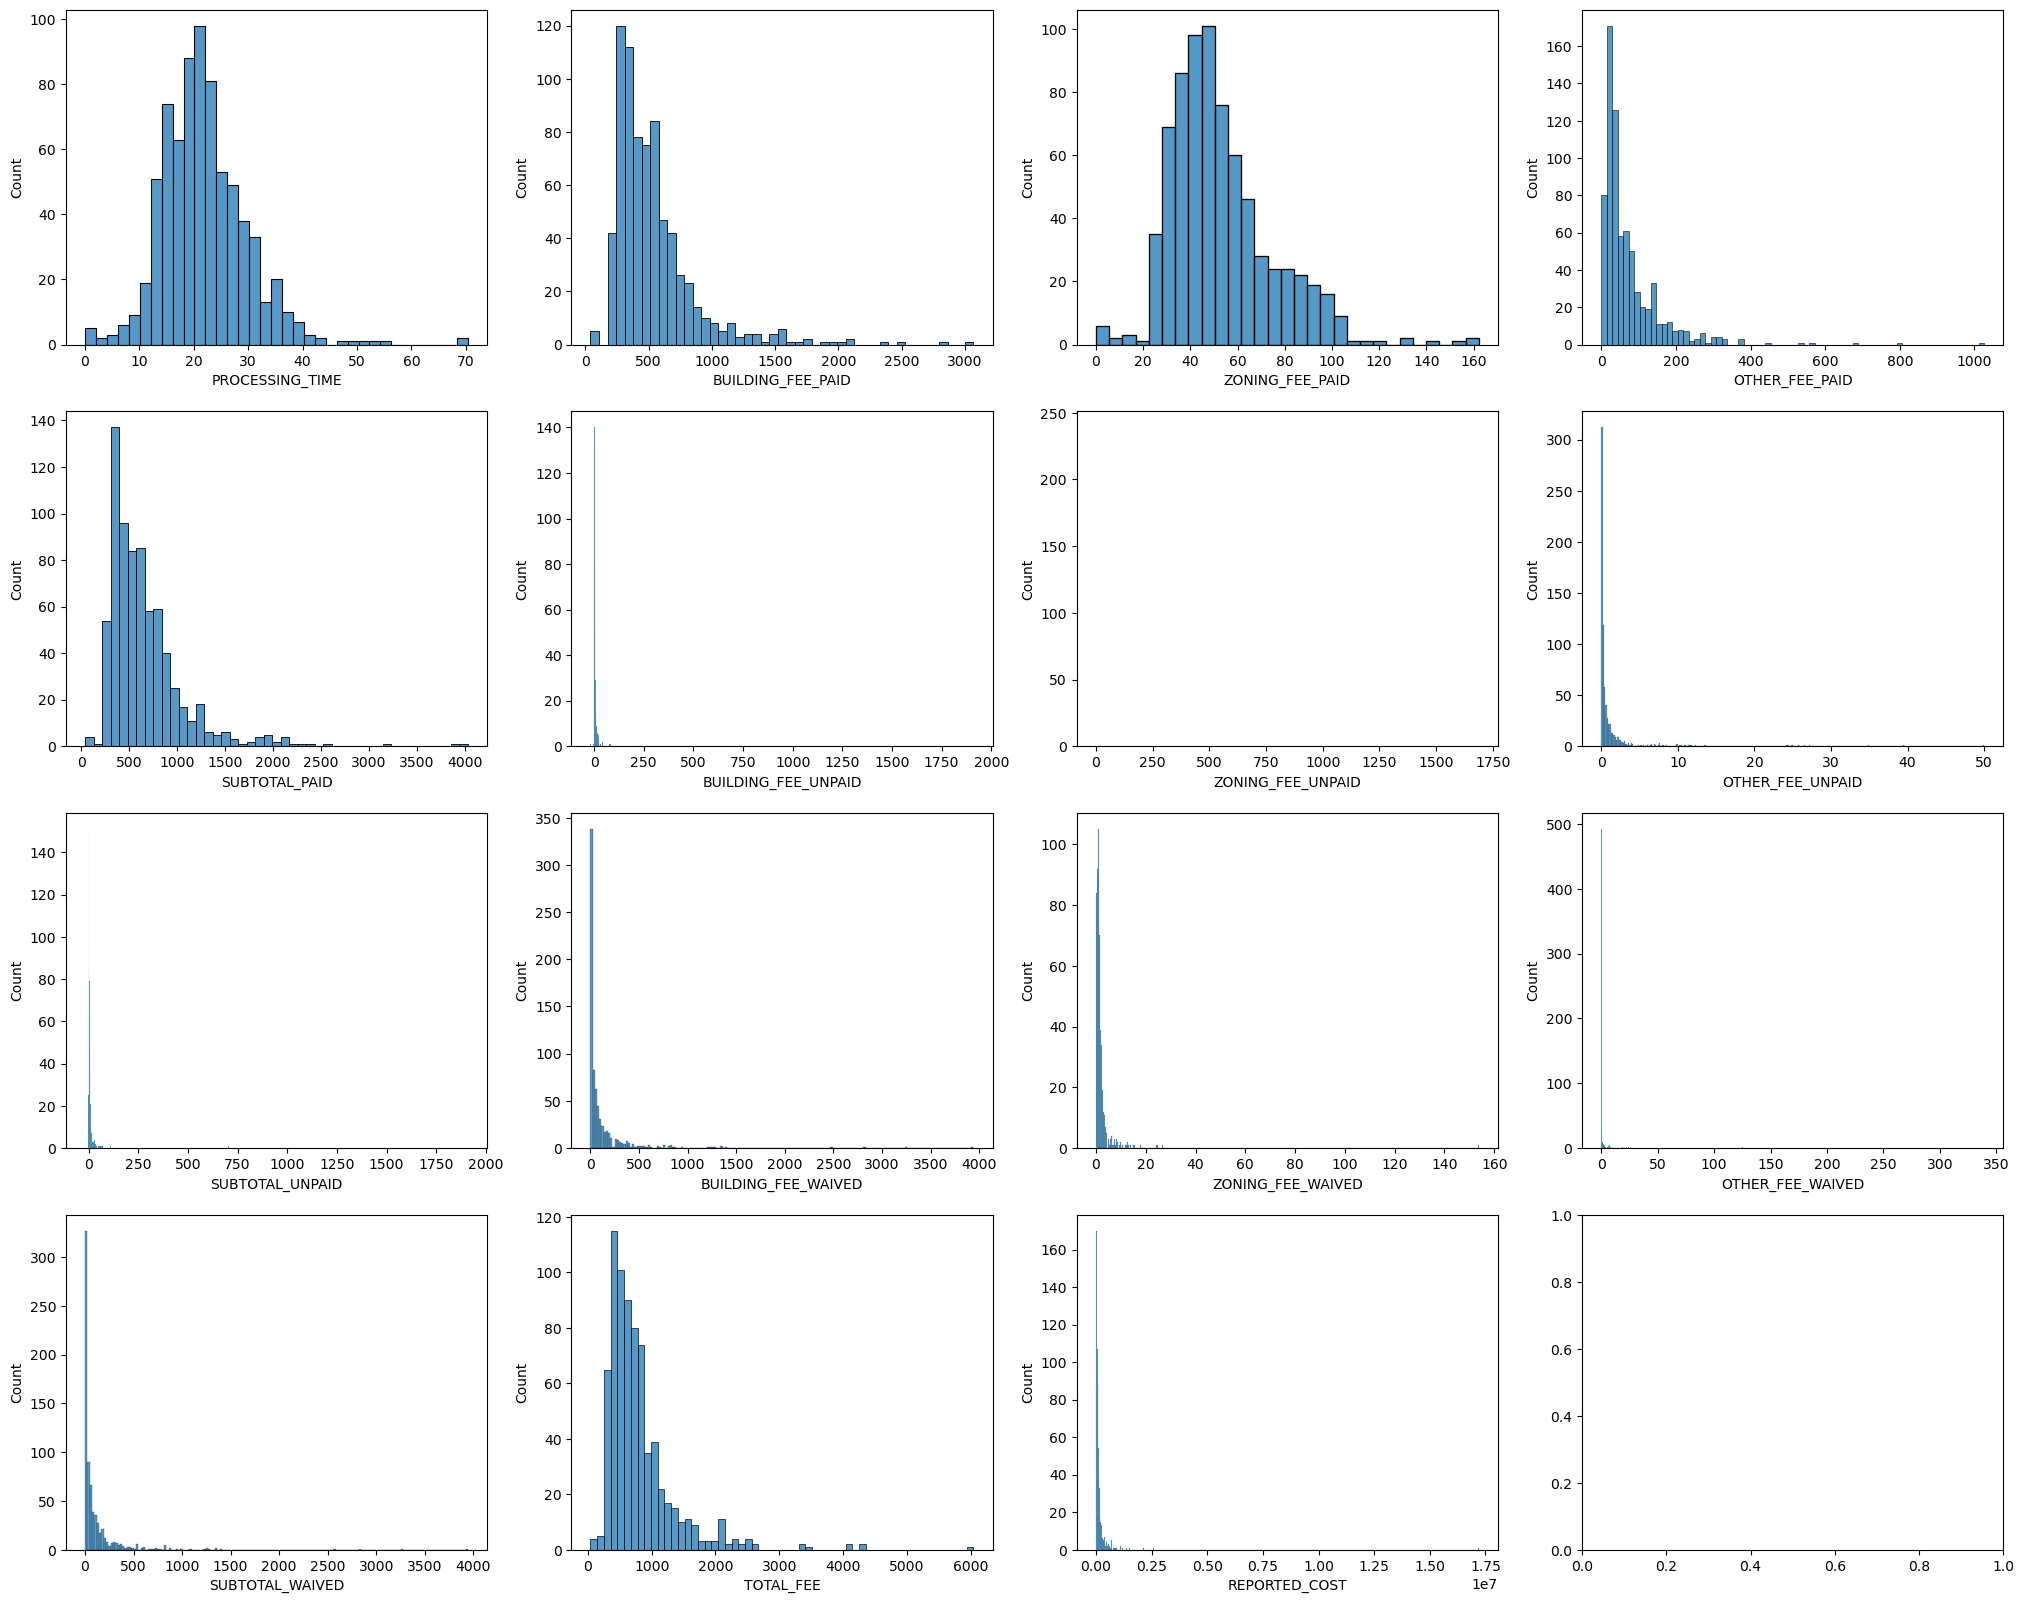

In [40]:
#MEAN
df_num_exploration_mean=df_num.groupby('CENSUS_TRACT').mean().applymap(lambda x: round(x,2))

plt.subplots(4, 4, figsize = (25, 20))
i = 1
for column in df_num_exploration_mean.columns:
    plt.subplot(4, 4, i)
    sns.histplot(data = df_num_exploration_mean[column].reset_index(drop=True))
    i += 1

* Even more outliers
    * Remove where possible
* Are there are any columns that carry no statistically significant information?

In [41]:
df_num.columns

Index(['PROCESSING_TIME', 'BUILDING_FEE_PAID', 'ZONING_FEE_PAID',
       'OTHER_FEE_PAID', 'SUBTOTAL_PAID', 'BUILDING_FEE_UNPAID',
       'ZONING_FEE_UNPAID', 'OTHER_FEE_UNPAID', 'SUBTOTAL_UNPAID',
       'BUILDING_FEE_WAIVED', 'ZONING_FEE_WAIVED', 'OTHER_FEE_WAIVED',
       'SUBTOTAL_WAIVED', 'TOTAL_FEE', 'REPORTED_COST', 'CENSUS_TRACT'],
      dtype='object')

In [42]:
thresholds = {}

for col in df_num.drop(columns='CENSUS_TRACT').columns:
   IQR = np.percentile(df_num[col], 75) - np.percentile(df_num[col], 25)
   threshold = 1.5 * IQR + np.percentile(df_num[col], 95)
   thresholds[col]=threshold

In [43]:
thresholds

{'PROCESSING_TIME': 115.0,
 'BUILDING_FEE_PAID': 2506.525,
 'ZONING_FEE_PAID': 312.5,
 'OTHER_FEE_PAID': 75.0,
 'SUBTOTAL_PAID': 2949.56,
 'BUILDING_FEE_UNPAID': 0.0,
 'ZONING_FEE_UNPAID': 0.0,
 'OTHER_FEE_UNPAID': 0.0,
 'SUBTOTAL_UNPAID': 0.0,
 'BUILDING_FEE_WAIVED': 0.0,
 'ZONING_FEE_WAIVED': 0.0,
 'OTHER_FEE_WAIVED': 0.0,
 'SUBTOTAL_WAIVED': 0.0,
 'TOTAL_FEE': 3212.5,
 'REPORTED_COST': 349250.0}

* Drop Columns where threshold is 0
* The columns in the main dataframe will be dropped in the end of the section
    * Create a list `to_drop` to keep track of the columns that will have to be dropped

In [44]:
df_test=pd.DataFrame()
df_test['CENSUS_TRACT']=df_num['CENSUS_TRACT'].copy()
col_drop=[]
col_valid=[]
for col, threshold in thresholds.items():
    if threshold >0:
        df_test[col]=[i if i<threshold else threshold for i in df_num[col]]
        col_valid.append(col)
    else:
        col_drop.append(col)

In [45]:
'''#select keys where value of the dictionary is 0
#save in a list which can be used in the end of this subsection to drop the unnecessary columns
to_drop=[k for k,v in thresholds.items() if v==0.0]
to_drop

#df_num=df_num.drop(columns=to_drop)'''

'#select keys where value of the dictionary is 0\n#save in a list which can be used in the end of this subsection to drop the unnecessary columns\nto_drop=[k for k,v in thresholds.items() if v==0.0]\nto_drop\n\n#df_num=df_num.drop(columns=to_drop)'

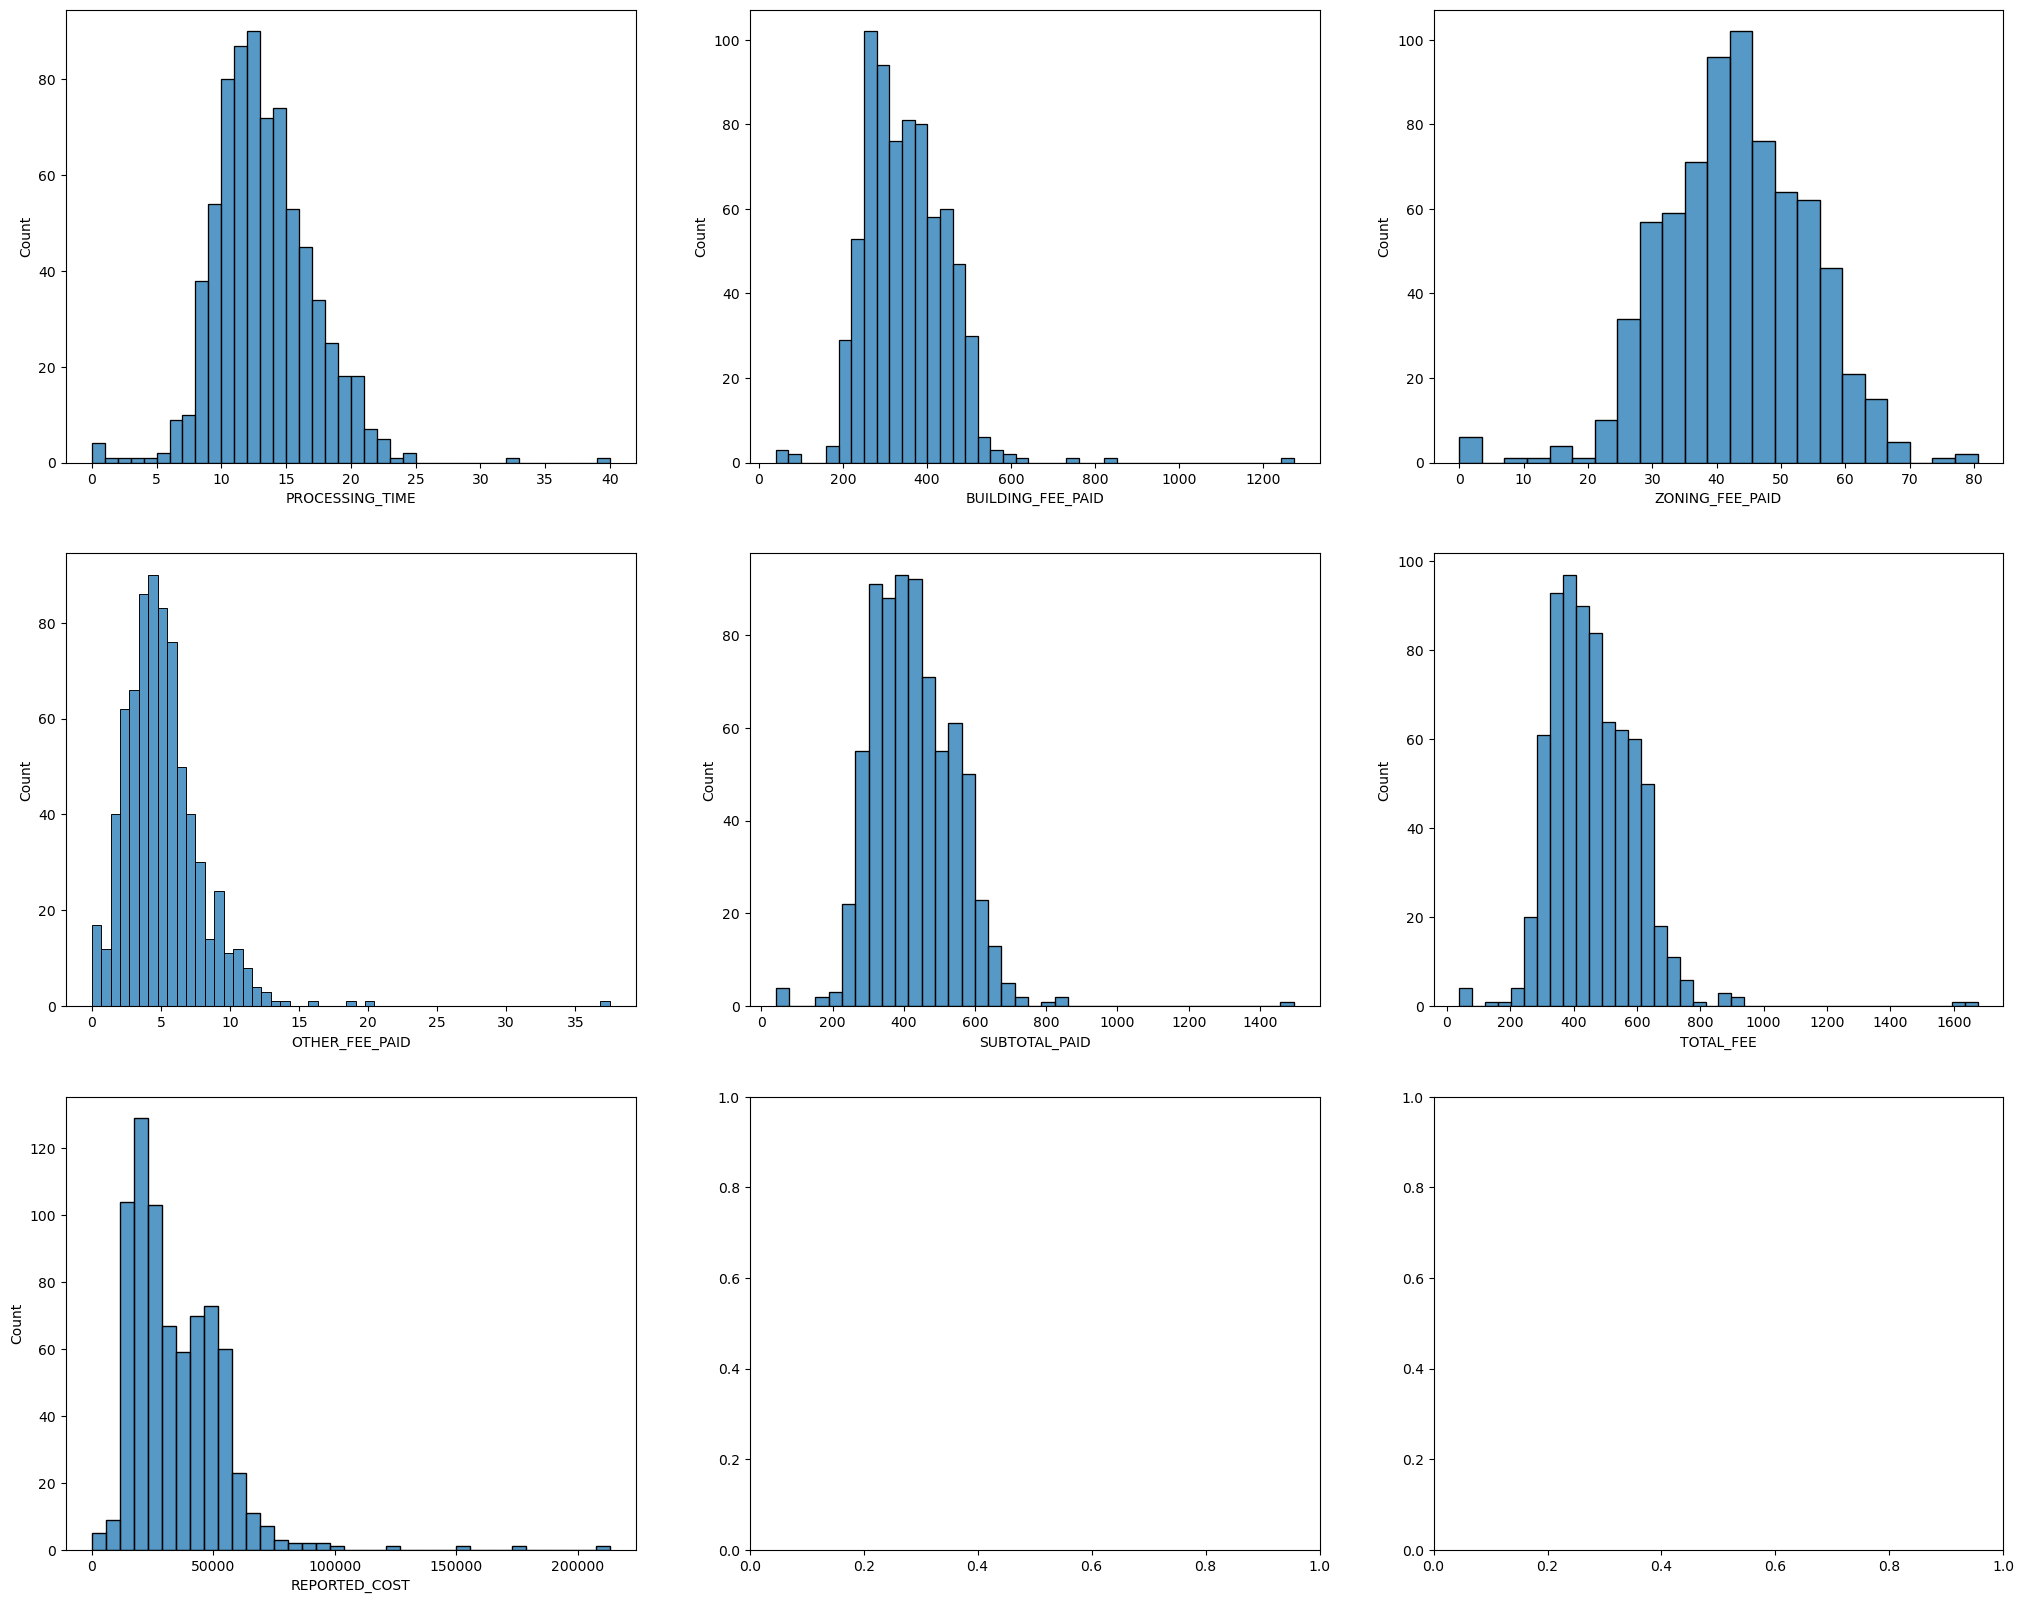

In [46]:
#MEAN
df_num_test_mean=df_test.groupby('CENSUS_TRACT').mean().applymap(lambda x: round(x,2))

plt.subplots(3, 3, figsize = (25, 20))
i = 1
for column in df_num_test_mean.columns:
    plt.subplot(3, 3, i)
    sns.histplot(data = df_num_test_mean[column].reset_index(drop=True))
    i += 1

In [47]:
col_valid

['PROCESSING_TIME',
 'BUILDING_FEE_PAID',
 'ZONING_FEE_PAID',
 'OTHER_FEE_PAID',
 'SUBTOTAL_PAID',
 'TOTAL_FEE',
 'REPORTED_COST']

In [48]:
def num_col_cleaning(df,thresholds_di):
    df_new=df.copy()
    '''This function cleans up numeric columns based on the previously established threshold'''
    for col, threshold in thresholds_di.items():
        if threshold >0:
            df_new[col]=[i if i<threshold else threshold for i in df[col]]
        else:
            df_new=df_new.drop(columns=col)
    return df_new

In [168]:
permits_scaled=num_col_cleaning(permits_clean,thresholds)

---
*<center><h3>Categorical Columns<center><h3>*

In [169]:
df_obj

,PERMIT_TYPE,REVIEW_TYPE,ISSUE_DATE,WORK_DESCRIPTION,CONTACT_1_TYPE,CONTACT_1_CITY,CONTACT_1_STATE
0,RENOVATION/ALTERATION,STANDARD PLAN REVIEW,2006-01-03,INTERIOR REMODELING OF EXISTING 3 D.U. PER PLA...,OWNER AS GENERAL CONTRACTOR,CHICAGO,IL
1,NEW CONSTRUCTION,STANDARD PLAN REVIEW,2006-03-29,"new construction, erect 3 story slab on grade ...",ARCHITECT,CHICAGO X,IL
2,SIGNS,SIGN PERMIT,2006-01-12,north elevation 386431,CONTRACTOR-ELECTRICAL,ROLLING MEADOWS,IL
3,RENOVATION/ALTERATION,SELF CERT,2006-01-26,Interior alteration of existing partial 34th f...,SELF CERT ARCHITECT,CHICAGO X,IL
4,RENOVATION/ALTERATION,SELF CERT,2006-01-21,Interior alterations to the retail space on th...,SELF CERT ARCHITECT,DEERFIELD X,IL
...,...,...,...,...,...,...,...
730506,EASY PERMIT PROCESS,EASY PERMIT,2023-02-24,SOLAR PANEL PERMIT. ERECT A PHOTOVOLTAIC ARRA...,STRUCTURAL ENGINEER,HOUSTON,TX
730507,EASY PERMIT PROCESS,EASY PERMIT WEB,2023-02-24,FENCES: 165FT 0IN X 6FT 0IN: QTY 1 (not to be ...,OWNER AS GENERAL CONTRACTOR,CHICAGO,IL
730508,ELECTRIC WIRING,EASY PERMIT WEB,2023-02-24,"TECH WILL PULL 100 CAT-6 CABLES, TERMINATE, AN...",CONTRACTOR-ELECTRICAL,LENEXA,KS
730509,EASY PERMIT PROCESS,EASY PERMIT,2023-02-24,REVISION TO PERMIT NO 100988130 TO CHANGE ELEC...,CONTRACTOR-ELECTRICAL,CHICAGO,IL


* Preview the number of unique categories within categorical columns over the years

In [170]:
#Ensure ISSUE_DATE format is datetime
df_obj['ISSUE_DATE']=df_obj['ISSUE_DATE'].astype('datetime64')

unique_yearly=df_obj.groupby(df_obj['ISSUE_DATE'].dt.year).nunique().drop(columns='ISSUE_DATE')
unique_yearly

,PERMIT_TYPE,REVIEW_TYPE,WORK_DESCRIPTION,CONTACT_1_TYPE,CONTACT_1_CITY,CONTACT_1_STATE
ISSUE_DATE,,,,,,
2006,11,10,37483,26,680,79
2007,11,10,36499,26,635,72
2008,11,10,31280,26,612,72
2009,10,10,30485,26,627,66
2010,9,10,30315,23,617,69
2011,9,10,30362,22,643,47
2012,9,10,31787,21,652,58
2013,9,10,33989,22,679,66
2014,9,10,37332,22,702,62


* Number of unique permit types decreased from 11 in 2006 to 9 in 2023
  * Meaning that the use of some permit types was discontinued

***
**Permit Type**

* Let's preview the distribution of different permit types
* Start by previewing the number of planning applications for each permit type

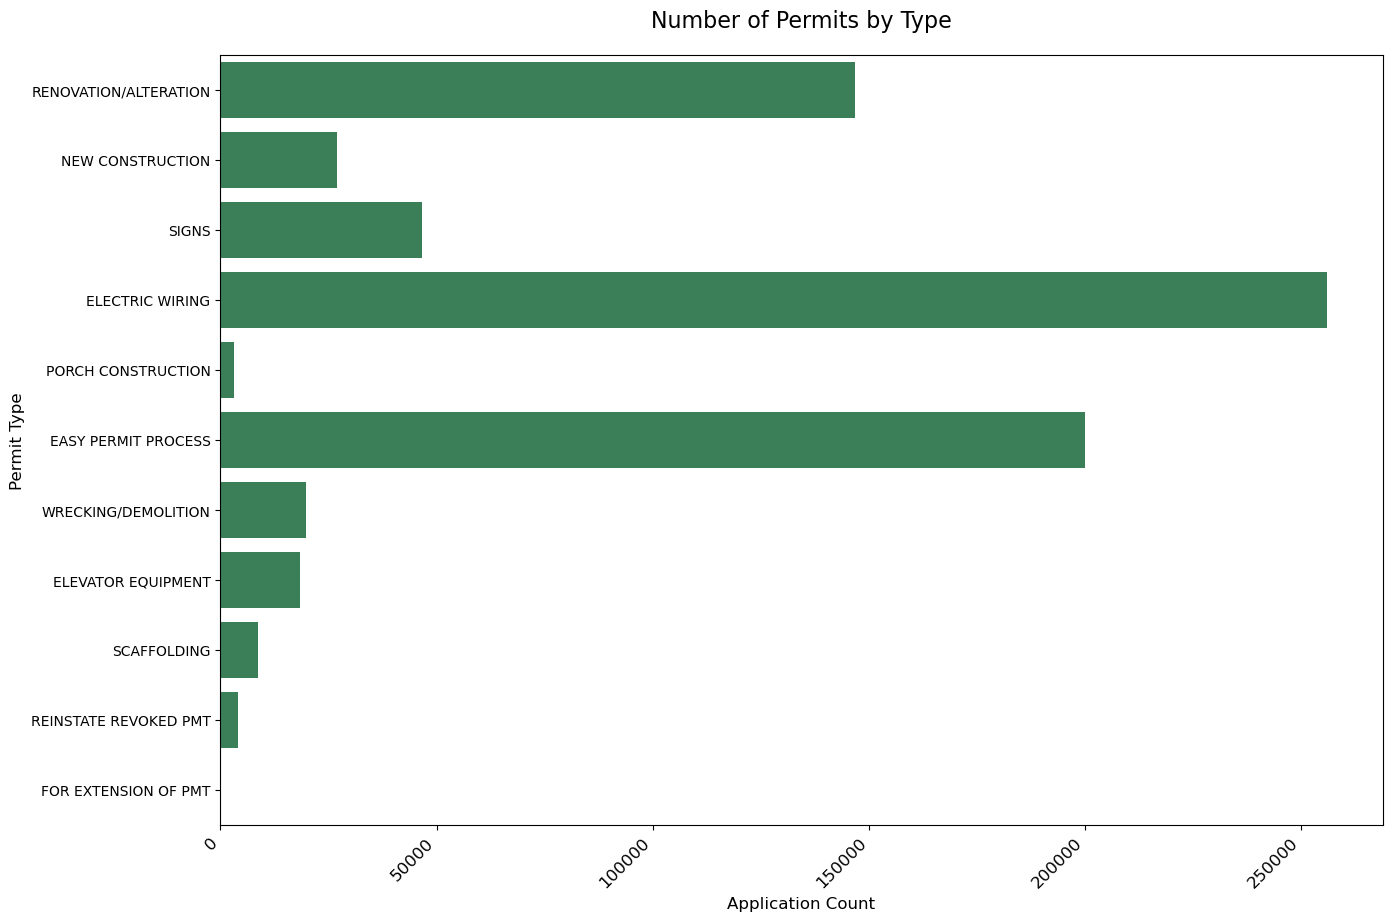

In [171]:
plt.figure(figsize=(15,10))
ax=sns.countplot(data=df_obj,y='PERMIT_TYPE',color='seagreen')
ax.set_title('Number of Permits by Type', fontsize=16, pad=20)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.ylabel('Permit Type', fontsize=12)
plt.xlabel('Application Count', fontsize=12)
plt.show()

* Preview the absolute counts for each permit type

In [172]:
df_obj['PERMIT_TYPE'].value_counts()

ELECTRIC WIRING          256012
EASY PERMIT PROCESS      199935
RENOVATION/ALTERATION    146854
SIGNS                     46707
NEW CONSTRUCTION          26974
WRECKING/DEMOLITION       19730
ELEVATOR EQUIPMENT        18456
SCAFFOLDING                8649
REINSTATE REVOKED PMT      4040
PORCH CONSTRUCTION         3096
FOR EXTENSION OF PMT         58
Name: PERMIT_TYPE, dtype: int64

*'FOR EXTENSION OF PMT' was only in 58 planning permits. Consider whether it is a special type of application which would be statistiaclly relevant or whether its use was discontinued instead*

* Check the differnce between the distinct permit types in 2006 and 2022

In [173]:
unique_yearly['PERMIT_TYPE']

ISSUE_DATE
2006    11
2007    11
2008    11
2009    10
2010     9
2011     9
2012     9
2013     9
2014     9
2015     9
2016     9
2017     9
2018     9
2019     9
2020     9
2021     9
2022     9
2023     9
Name: PERMIT_TYPE, dtype: int64

In [174]:
distict_permit_types_2006=set(df_obj[df_obj['ISSUE_DATE'].dt.year==2006]['PERMIT_TYPE'].unique())
distict_permit_types_2022=set(df_obj[df_obj['ISSUE_DATE'].dt.year==2022]['PERMIT_TYPE'].unique())
distict_permit_types_2006.symmetric_difference(distict_permit_types_2022)

{'FOR EXTENSION OF PMT', 'PORCH CONSTRUCTION'}

* 'FOR EXTENSION OF PMT', 'PORCH CONSTRUCTION' were permit types in 2006 but were discontinued by 2022. Hence, using them for future predictions will not be useful
* Rename 'FOR EXTENSION OF PMT', 'PORCH CONSTRUCTION' to 'DROP'
* Remember to drop `'PERMIT_TYPE_DROP'` before modelling

In [175]:
permits_scaled['PERMIT_TYPE']=permits_scaled['PERMIT_TYPE'].replace({'FOR EXTENSION OF PMT':'DROP','PORCH CONSTRUCTION':'DROP'})

In [176]:
permits_scaled.groupby('PERMIT_TYPE')['REPORTED_COST'].mean()

PERMIT_TYPE
DROP                      14157.760675
EASY PERMIT PROCESS       19543.316834
ELECTRIC WIRING            8020.178047
ELEVATOR EQUIPMENT        80833.635328
NEW CONSTRUCTION         205926.590728
REINSTATE REVOKED PMT      3968.379795
RENOVATION/ALTERATION     99441.110747
SCAFFOLDING                  62.744276
SIGNS                      4271.306490
WRECKING/DEMOLITION        7542.140506
Name: REPORTED_COST, dtype: float64

* Consider reported cost, as more investment into a neighbourhood, the more likely it is is to gentrify

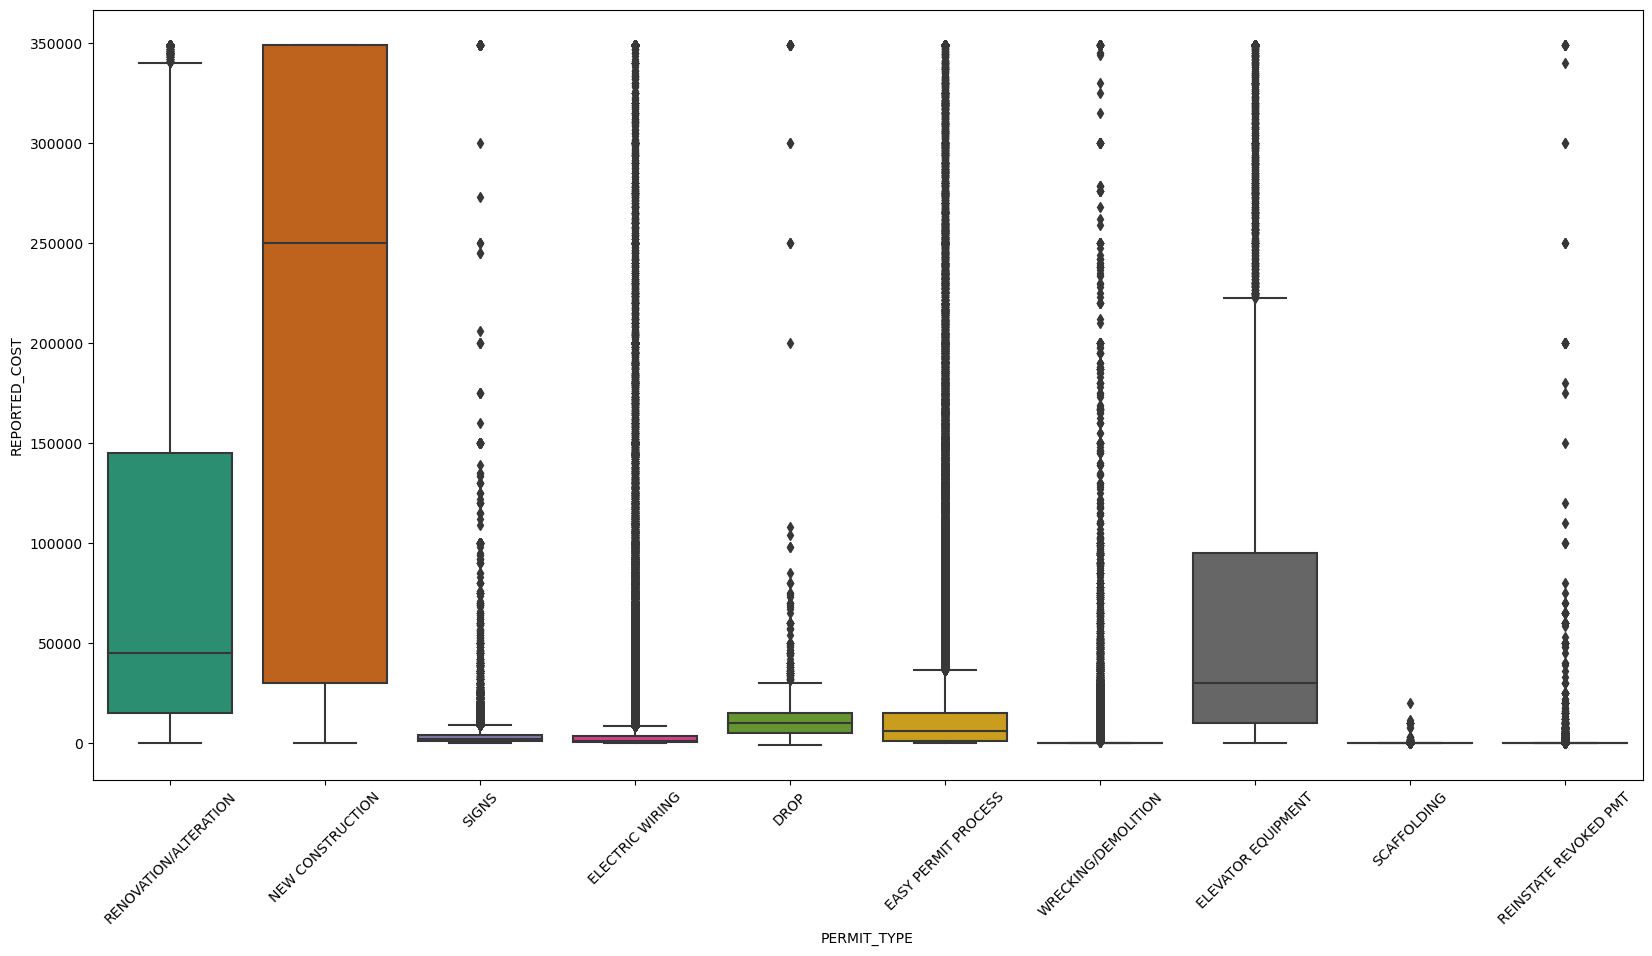

In [177]:
fig, ax = plt.subplots(figsize=(20,10))

sns.boxplot(data=permits_scaled, x='PERMIT_TYPE', y='REPORTED_COST', palette=sns.color_palette('Dark2'))

plt.xticks(rotation=45);

* Let's attempt to categorise Permit Type by the expected length of construction (in other words, expected time lag between the urban fabric change and its impact on the census tract demographics)

***
* ***What is the relationship between Permit Type and Review Type?***

In [178]:
#groupby REVIEW_TYPE & PERMIT_TYPE to view unique pair combinations
check=permits_scaled.groupby(['REVIEW_TYPE','PERMIT_TYPE']).size().reset_index()[['REVIEW_TYPE','PERMIT_TYPE']]
check

,REVIEW_TYPE,PERMIT_TYPE
0,CONVEYANCE DEVICE PERMIT,ELEVATOR EQUIPMENT
1,DEMOLITION PERMIT,WRECKING/DEMOLITION
2,DIRECT DEVELOPER SERVICES,NEW CONSTRUCTION
3,DIRECT DEVELOPER SERVICES,RENOVATION/ALTERATION
4,EASY PERMIT,DROP
5,EASY PERMIT,EASY PERMIT PROCESS
6,EASY PERMIT,NEW CONSTRUCTION
7,EASY PERMIT,REINSTATE REVOKED PMT
8,EASY PERMIT,RENOVATION/ALTERATION
9,EASY PERMIT,SCAFFOLDING


In [179]:
dup_pairs=[]
for i,row in check.iterrows():
    condition_one=(check[check['REVIEW_TYPE']==row['REVIEW_TYPE']]).shape[0]==1
    condition_two=(check[check['PERMIT_TYPE']==row['PERMIT_TYPE']]).shape[0]==1
    if condition_one&condition_two:
        dup_pairs.append((row['REVIEW_TYPE'],row['PERMIT_TYPE']))
dup_pairs

[('CONVEYANCE DEVICE PERMIT', 'ELEVATOR EQUIPMENT'),
 ('DEMOLITION PERMIT', 'WRECKING/DEMOLITION'),
 ('SIGN PERMIT', 'SIGNS')]

* The pairs of review and permit types above form a one-to-one match. One of them needs to be dropped
* Let's rename the permit types `'ELEVATOR EQUIPMENT', 'WRECKING/DEMOLITION', 'SIGNS'` to be called `DROP`
* Remember to drop `'PERMIT_TYPE_DROP'` before modelling

In [180]:
permits_scaled['PERMIT_TYPE']=permits_scaled['PERMIT_TYPE'].replace({'ELEVATOR EQUIPMENT':'DROP','WRECKING/DEMOLITION':'DROP','SIGNS':'DROP'})

In [181]:
permits_scaled['PERMIT_TYPE'].unique()

array(['RENOVATION/ALTERATION', 'NEW CONSTRUCTION', 'DROP',
       'ELECTRIC WIRING', 'EASY PERMIT PROCESS', 'SCAFFOLDING',
       'REINSTATE REVOKED PMT'], dtype=object)

***
**Review Type**

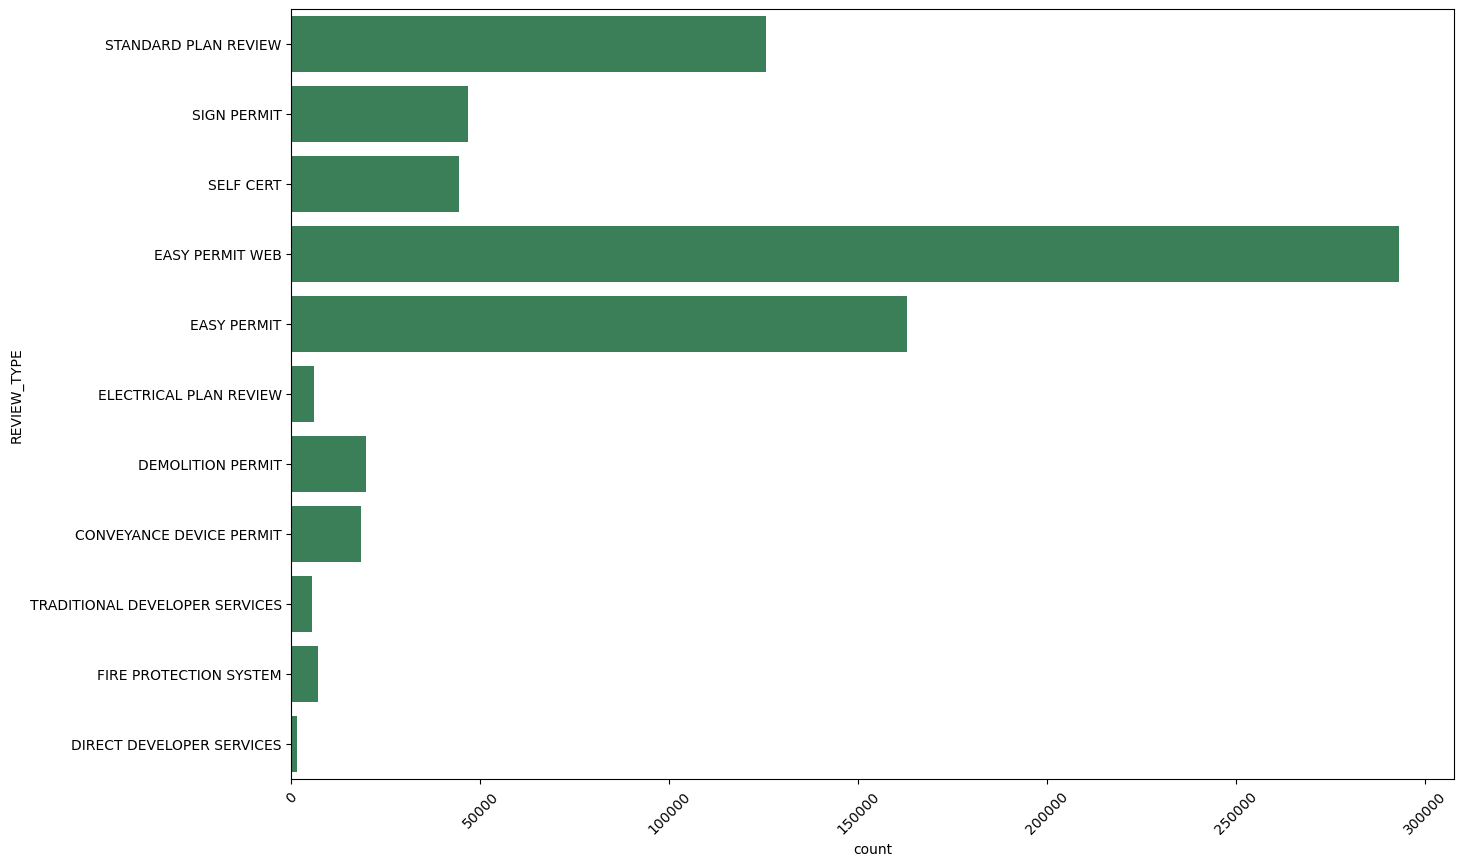

In [182]:
plt.figure(figsize=(15,10))
sns.countplot(data=df_obj,y='REVIEW_TYPE',color='seagreen',orient="h")
plt.xticks(rotation=45);

In [183]:
df_obj['REVIEW_TYPE'].value_counts()

EASY PERMIT WEB                   292975
EASY PERMIT                       162936
STANDARD PLAN REVIEW              125643
SIGN PERMIT                        46707
SELF CERT                          44408
DEMOLITION PERMIT                  19730
CONVEYANCE DEVICE PERMIT           18456
FIRE PROTECTION SYSTEM              6927
ELECTRICAL PLAN REVIEW              5991
TRADITIONAL DEVELOPER SERVICES      5365
DIRECT DEVELOPER SERVICES           1373
Name: REVIEW_TYPE, dtype: int64

* DIRECT DEVELOPER SERVICES has the smallest count
* Consider if it was present in all years

In [184]:
unique_yearly['REVIEW_TYPE']

ISSUE_DATE
2006    10
2007    10
2008    10
2009    10
2010    10
2011    10
2012    10
2013    10
2014    10
2015    11
2016    11
2017    11
2018    11
2019    11
2020    11
2021    11
2022    11
2023    11
Name: REVIEW_TYPE, dtype: int64

* One Review Type was added between 2006 and 2023
* Check if it was `DIRECT DEVELOPER SERVICES`

In [185]:
distict_review_types_2006=set(df_obj[df_obj['ISSUE_DATE'].dt.year==2006]['REVIEW_TYPE'].unique())
distict_review_types_2022=set(df_obj[df_obj['ISSUE_DATE'].dt.year==2022]['REVIEW_TYPE'].unique())
distict_review_types_2006.symmetric_difference(distict_review_types_2022)

{'DIRECT DEVELOPER SERVICES'}

* DIRECT DEVELOPER SERVICES was only added in 2015. Hence, it will be missing in the early years.</br>
* While it is unlikely to be a good predictor in the current model due to the lack of datapoints with DIRECT DEVELOPER SERVICES, it might become a good predictor in the future
* Hence, let's not drop it but when running stastical tests be mindful that it might not show any correlations when the model is trained on the data from years before 2015

***
***CONTACT_1_TYPE***

In [186]:
permits_scaled['CONTACT_1_TYPE'].unique()

array(['OWNER AS GENERAL CONTRACTOR', 'ARCHITECT',
       'CONTRACTOR-ELECTRICAL', 'SELF CERT ARCHITECT', 'UNKNOWN',
       'CONTRACTOR-GENERAL CONTRACTOR', 'SIGN CONTRACTOR',
       'STRUCTURAL ENGINEER', 'OWNER', 'OWNER AS ARCHITECT & CONTRACTR',
       'OWNER OCCUPIED', 'CONTRACTOR-ELEVATOR', 'EXPEDITOR',
       'BUILDING OWNER', 'CONTRACTOR-WRECKING', 'CONTRACTOR-VENTILATION',
       'CONTRACTOR-PLUMBER/PLUMBING', 'OWNER AS ARCHITECT',
       'TENT CONTRACTOR', 'MASON - BRICK AND CONCRETE',
       'MASON - BRICK ONLY', 'MASONRY CONTRACTOR', 'CONTRACTOR-HEATING',
       'PLUMBING CONTRACTOR', 'MASON - CONCRETE ONLY',
       'RESIDENTAL REAL ESTATE DEV', 'CONTRACTOR-REFRIGERATION'],
      dtype=object)

<AxesSubplot:xlabel='count', ylabel='CONTACT_1_TYPE'>

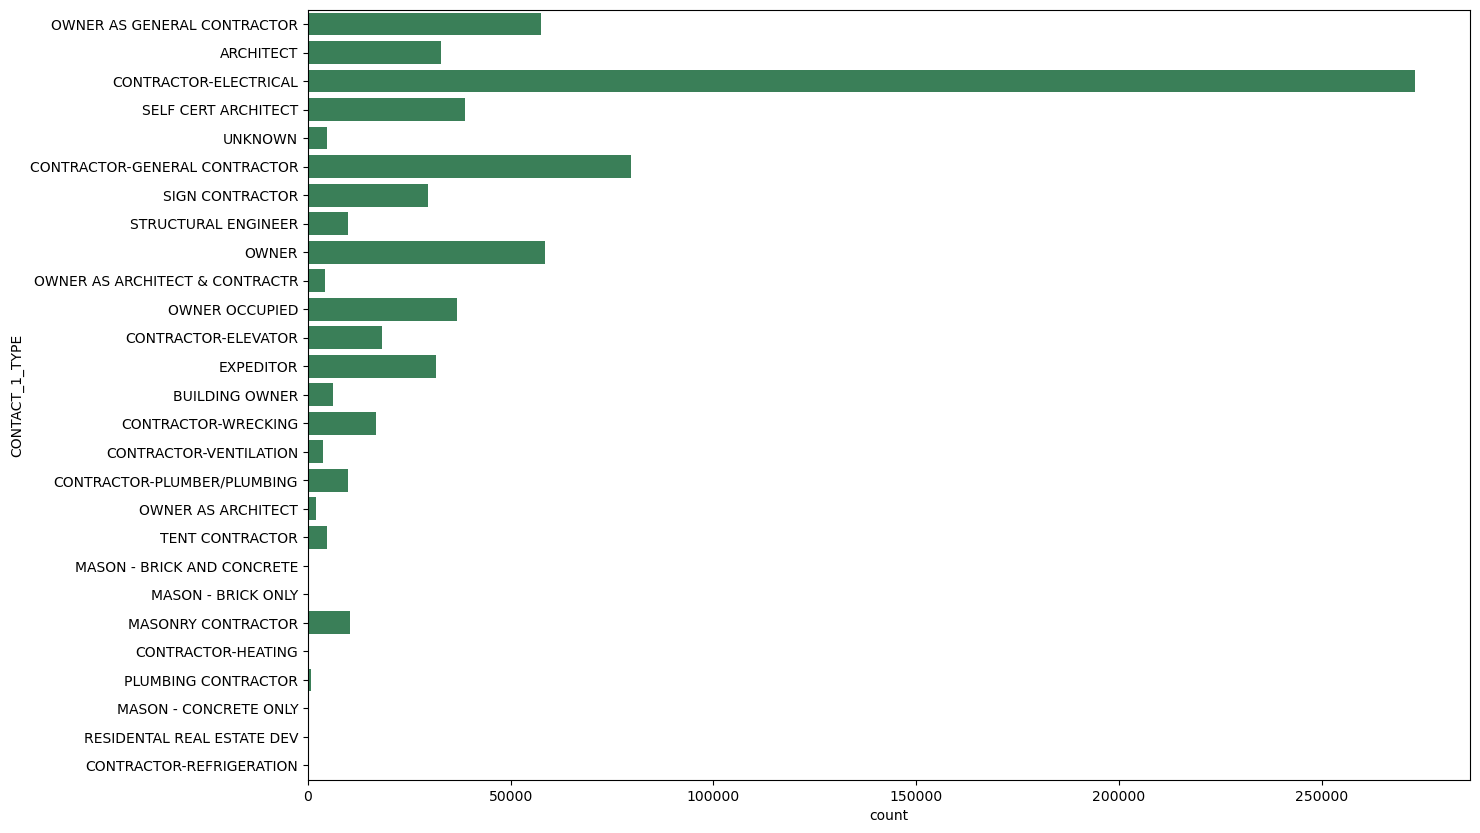

In [187]:
plt.figure(figsize=(15,10))
sns.countplot(data=df_obj,y='CONTACT_1_TYPE',color='seagreen',orient="h")
#plt.xticks(rotation=45);

In [188]:
#absolute values
df_obj['CONTACT_1_TYPE'].value_counts()

CONTRACTOR-ELECTRICAL             272995
CONTRACTOR-GENERAL CONTRACTOR      79675
OWNER                              58533
OWNER AS GENERAL CONTRACTOR        57524
SELF CERT ARCHITECT                38748
OWNER OCCUPIED                     36737
ARCHITECT                          32752
EXPEDITOR                          31478
SIGN CONTRACTOR                    29689
CONTRACTOR-ELEVATOR                18284
CONTRACTOR-WRECKING                16678
MASONRY CONTRACTOR                 10383
CONTRACTOR-PLUMBER/PLUMBING         9975
STRUCTURAL ENGINEER                 9840
BUILDING OWNER                      6122
UNKNOWN                             4773
TENT CONTRACTOR                     4665
OWNER AS ARCHITECT & CONTRACTR      4238
CONTRACTOR-VENTILATION              3750
OWNER AS ARCHITECT                  1874
PLUMBING CONTRACTOR                  816
MASON - BRICK AND CONCRETE           315
MASON - BRICK ONLY                   224
CONTRACTOR-HEATING                   202
CONTRACTOR-REFRI

Note 1:
* RESIDENTAL REAL ESTATE DEV has only 2 counts, let's rename it to `DROP`
* Remember to drop `'CONTACT_1_TYPE_DROP'` before modelling

In [189]:
permits_scaled['CONTACT_1_TYPE']=permits_scaled['CONTACT_1_TYPE'].replace({'CONTACT_1_TYPE_DROP':'DROP'})

Note 2:
* Categories `'MASON - BRICK AND CONCRETE'`, `'MASON - BRICK ONLY'` and `'MASON - CONCRETE ONLY'` all have low counts
* Let's merge them all together into **'MASON - BRICK AND CONCRETE'** since they all refer to masonry contractor working with brick and concrete


In [190]:
permits_scaled['CONTACT_1_TYPE']=permits_scaled['CONTACT_1_TYPE'].replace({'MASON - BRICK ONLY':'MASON - BRICK AND CONCRETE','MASON - CONCRETE ONLY':'MASON - BRICK AND CONCRETE'})

Note 3:
* Categories `CONTRACTOR-HEATING` and `CONTRACTOR-REFRIGERATION` both reger to a Contractor working with heating, ventilation and air conditioning
* Since they have counts, let's also merge them together into **CONTRACTOR-ENERGY**

***
***CONTACT_1_CITY***

In [192]:
print(permits_scaled['CONTACT_1_CITY'].value_counts()[0:25])
print('\n')
print(permits_scaled['CONTACT_1_CITY'].value_counts().shape[0])

CHICAGO              341031
CHICAGO X             15248
MINOOKA               12798
OAK BROOK             12758
CHGO                  11960
NORTHBROOK            10484
ELK GROVE VILLAGE     10323
UNKNOWN               10305
IRVING                 8685
ADDISON                7723
LOMBARD                7555
DOWNERS GROVE          7102
SKOKIE                 6874
ARLINGTON HEIGHTS      5891
PARK RIDGE             5754
DES PLAINES            5333
SCHAUMBURG             5127
ELMHURST               4881
ELGIN                  4646
OAK LAWN               4504
SUMMIT                 4467
ROLLING MEADOWS        4457
GLENVIEW               4006
MELROSE PARK           3972
ALSIP                  3916
Name: CONTACT_1_CITY, dtype: int64


2576


* Let's rename apelling variatios of Chicago to CHICAGO

In [195]:
permits_scaled['CONTACT_1_CITY'].value_counts()[1:16].index

Index(['MINOOKA', 'OAK BROOK', 'NORTHBROOK', 'ELK GROVE VILLAGE', 'UNKNOWN',
       'IRVING', 'ADDISON', 'LOMBARD', 'DOWNERS GROVE', 'SKOKIE',
       'ARLINGTON HEIGHTS', 'PARK RIDGE', 'DES PLAINES', 'SCHAUMBURG',
       'ELMHURST'],
      dtype='object')

In [196]:
permits_scaled['CONTACT_1_CITY']=permits_scaled['CONTACT_1_CITY'].replace({'CHICAGO X':'CHICAGO','CHGO':'CHICAGO'})

#top 14 cities apart from Chicago
cities=list(permits_scaled['CONTACT_1_CITY'].value_counts()[1:14].index)
cities.append('CHICAGO')
permits_scaled['CONTACT_1_CITY']=[x if x in cities else 'OTHER' for x in permits_scaled['CONTACT_1_CITY']]

In [197]:
print(permits_scaled['CONTACT_1_CITY'].value_counts()[0:25])

CHICAGO              368239
OTHER                250687
MINOOKA               12798
OAK BROOK             12758
NORTHBROOK            10484
ELK GROVE VILLAGE     10323
UNKNOWN               10305
IRVING                 8685
ADDISON                7723
LOMBARD                7555
DOWNERS GROVE          7102
SKOKIE                 6874
ARLINGTON HEIGHTS      5891
PARK RIDGE             5754
DES PLAINES            5333
Name: CONTACT_1_CITY, dtype: int64


---
***CONTACT_1_STATE***

In [200]:
print(permits_scaled['CONTACT_1_STATE'].value_counts()[0:25])
print('\n')
print(permits_scaled['CONTACT_1_STATE'].value_counts().shape[0])

IL          684614
TX            9794
UNKNOWN       6903
IN            5345
CA            4784
WI            2698
UT            1841
ILLINOIS      1684
NJ            1537
FL            1158
IL.           1113
MI             982
NY             835
GA             765
60             716
ILL            671
OH             602
MO             599
KS             432
PA             343
MN             268
MA             248
CO             212
TN             200
AZ             182
Name: CONTACT_1_STATE, dtype: int64


220


In [201]:
permits_scaled['CONTACT_1_STATE']=permits_scaled['CONTACT_1_STATE'].replace({'ILLINOIS':'IL','ILL':'IL','IL.':'IL'})

In [202]:
states=['IL','TX','IN','CA','WI','UT','NJ','FL','MI','NY']
permits_scaled['CONTACT_1_STATE']=[x if x in states else 'OTHER' for x in permits_scaled['CONTACT_1_STATE']]

In [232]:
permits_scaled['CONTACT_1_STATE'].value_counts()

IL       688082
OTHER     13455
TX         9794
IN         5345
CA         4784
WI         2698
UT         1841
NJ         1537
FL         1158
MI          982
NY          835
Name: CONTACT_1_STATE, dtype: int64

In [244]:
#Create another feature that is the contact in IL state but not Chicago
condition_one=permits_scaled['CONTACT_1_CITY'].isin(['UNKNOWN', 'OTHER'])
condition_two=permits_scaled['CONTACT_1_STATE']!='IL'
permits_scaled.loc[(condition_one&condition_two),'CONTACT_1_CITY']='CHICAGO_SUBURBS'

---
### EDA for NLP
*Sample of Work Descriptions*

In [245]:
for n in range(0,700000,50000):
    print(df_wip2['WORK_DESCRIPTION'][n])

NameError: name 'df_wip2' is not defined

#restaurant

`Analysed and cleaned in the next notebook`

* Analyse by most occuring words
* Analyse per permit type

In [ ]:
# government can only access census data
# not collected regularly
# what other indicators might be useful to epxlore gentrification
# how much information contains in the planning applications that is useful 
# it is not going to be enough 
# how influential planning application is 
# spot checks -> is there a trend that is missing
# 

In [247]:
'CONTACT_1_TYPE_DROP'

'CONTACT_1_TYPE_DROP'

In [250]:
permits_scaled=permits_scaled.drop(columns='ID')

In [251]:
permits_scaled.to_csv('../data/interim/permits_cleaned.csv')

***

*Further Thoughts*:
* Could clustering be used to find patterns between census tracts
* Is it valid to compare all districts using the same metrics?
    * Some are more urban, some are more suburban?
    * Is it possible to instead compare the change?
        * EG. How the number of applications changed in comparison to the last 5 years
        * Then need to compare to the average change
            * (X_new/X_old)/(Mean_new/Mean_old)
            * In other words, what is the percentage increase in the number of applications with respect to the overall city change?
